<a href="https://colab.research.google.com/github/muga01/TMAWrapper/blob/main/fastAlgo_1_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Some Context

It happens that time is not on our side. We need to make a quick decision on certain matters as quickly as possible. Developers intending to re-use or implement exact text searching algorithms often ask themselves on which algorithm we should pick out of the many algorithms available. They manually test each algorithm to find the one providing the fastest speed based on their test case. This is a lengthy process demanding resources and time. We propose a tool in which based on the test case, the user is proposed with the fastest exact text searching algorithm in no time. This way developers concentrate in more advanced tasks which require human presence and expertise. 

# Data quick check




## Data Load

In [1]:
#!pip install pandas-bokeh
# !pip install ipympl
# !pip install plotly

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import urllib.request
import pandas as pd
import seaborn as sns
import panel as pn
import panel.widgets as pnw
from matplotlib.figure import Figure
from matplotlib.ticker import ScalarFormatter
import warnings
warnings.filterwarnings("ignore")
pn.extension()
#import pandas_bokeh
#pandas_bokeh.output_notebook()
# %matplotlib inline
# %matplotlib widget

In [3]:
# Dataset URL Parameters
DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/muga01/TMAWrapper/main/'
DATASET_PATH = 'dataset'
DATASET_TOKEN ='token=GHSAT0AAAAAABVV3RXVRA3CG6LSZAIKK4XEYXWGSSQ'
DATASET_URL = DOWNLOAD_ROOT + 'dataset/string_pattern_matching.csv?' #+DATASET_TOKEN

def fetch_matching_data(dataset_source=DATASET_URL,dataset_dest=DATASET_PATH):
    os.makedirs(dataset_dest,exist_ok=True)
    dataset_file_name = os.path.join(dataset_dest,'string_pattern_matching.csv')
    data = urllib.request.urlretrieve(dataset_source,dataset_file_name)

def load_matching_data(data_source_path=DATASET_PATH):
    csv_path = os.path.join(data_source_path,'string_pattern_matching.csv')
    return pd.read_csv(csv_path)

In [4]:
fetch_matching_data()
matching_data = load_matching_data()
matching_data.head()

,Category,Text Size [MB],Pattern Length,Alphabet Size,Time [ms],Algorithm,Best Algo
0,rand2,1.0,2,2.0,0.00,AOSO2,NaN
1,rand2,1.0,4,2.0,14.37,AOSO2,NaN
2,rand2,1.0,8,2.0,6.56,AOSO2,NaN
3,rand2,1.0,16,2.0,1.83,AOSO2,NaN
4,rand2,1.0,32,2.0,1.33,AOSO2,NaN


## Data Cleaning

In [5]:
matching_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8640 entries, 0 to 8639
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Category        8640 non-null   object 
 1   Text Size [MB]  8640 non-null   float64
 2   Pattern Length  8640 non-null   int64  
 3   Alphabet Size   8640 non-null   float64
 4   Time [ms]       8640 non-null   float64
 5   Algorithm       8640 non-null   object 
 6   Best Algo       488 non-null    object 
dtypes: float64(3), int64(1), object(3)
memory usage: 472.6+ KB


We observe the column Best Algo missing some values. This is intentional as for each test experiment that is for different combinations of [text category, text size, pattern length, alphabet size] each algorithm reports it's speed and among all those speeds the best one is placed under the column Best Algo. We will train our model based on Best Algo label.

# Data Exploration and Visualization

In [6]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "Experiments"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Dataset High Level Information

In [7]:
matching_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8640 entries, 0 to 8639
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Category        8640 non-null   object 
 1   Text Size [MB]  8640 non-null   float64
 2   Pattern Length  8640 non-null   int64  
 3   Alphabet Size   8640 non-null   float64
 4   Time [ms]       8640 non-null   float64
 5   Algorithm       8640 non-null   object 
 6   Best Algo       488 non-null    object 
dtypes: float64(3), int64(1), object(3)
memory usage: 472.6+ KB




*   The dataset contains 8640 instances with 7 columns.
*   The dataset has 4 numerical and 3 categorical/string attributes
*The Best Algo column has null values.



## Statistical distribution of numerical attributes

In [8]:
matching_data.describe()


,Text Size [MB],Pattern Length,Alphabet Size,Time [ms]
count,8640.00000,8640.000000,8640.00000,8640.000000
mean,16.50000,204.600000,74.00000,51.541698
std,19.60343,312.985907,70.47393,123.266517
min,1.00000,2.000000,2.00000,0.000000
25%,4.00000,8.000000,14.00000,2.520000
50%,7.50000,48.000000,64.00000,9.810000
75%,20.00000,256.000000,128.00000,41.532500
max,50.00000,1024.000000,250.00000,1554.760000




*   We have an algorithm(s) which took close to 1.5s to look for a pattern.
*   We only have positive numbers thus we will have more scaling options including logarithmic based.



Saving figure numerical attributes


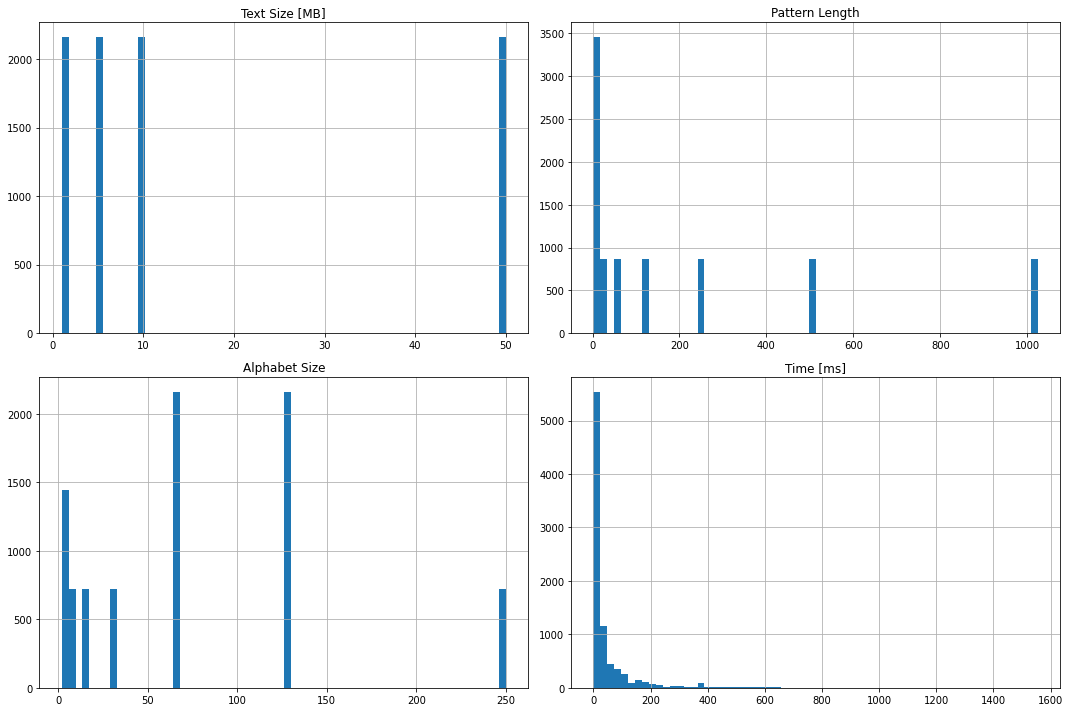

In [9]:
_=matching_data.hist(bins=64,figsize=(15,10))
save_fig('numerical attributes')



*   The attributes have different scales except pattern length and Alphabet size which looks like they follow the same scale.
* Time attribute follows exponential curve.



## Categorical attributes distribution

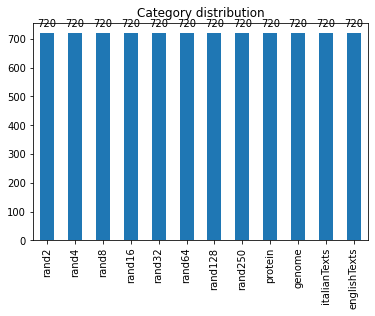

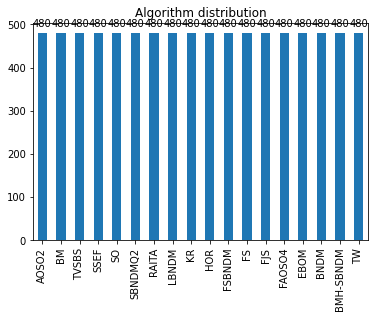

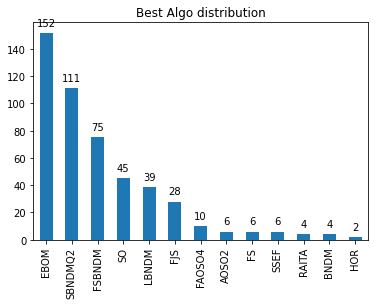

In [10]:
column_names = ['Category','Algorithm','Best Algo']

for col in column_names:
    plt.figure()
    plt.title(f'{col} distribution')
    ax=matching_data[col].value_counts().plot(kind='bar')
    for p in ax.patches:
        ax.annotate(np.round(p.get_height(),decimals=2),
                    (p.get_x()+p.get_width()/2., p.get_height()),
                    va='center',
                    ha='center',
                    xytext=(0, 10),
                    textcoords='offset points'
                    )

    
    

Saving figure algorithms


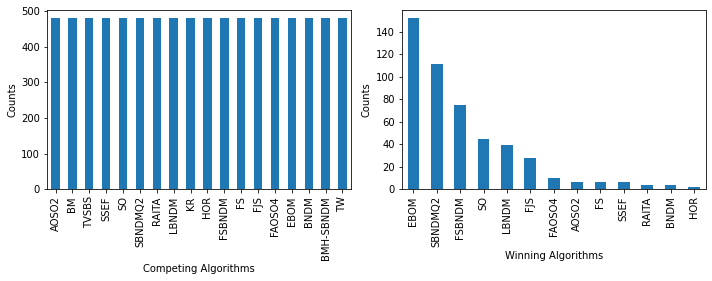

In [11]:
# Pretty Graph for a report
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
# sns.barplot(matching_data['Algorithm'].unique(),matching_data['Algorithm'].value_counts(),ax=ax1)
matching_data['Algorithm'].value_counts().plot(kind='bar',ax=ax1)
ax1.set_xlabel('Competing Algorithms')
ax1.set_ylabel('Counts')
# _=ax1.set_xticklabels(matching_data['Algorithm'].unique(),rotation = 90)

matching_data['Best Algo'].value_counts().plot(kind='bar',ax=ax2)
ax2.set_xlabel('Winning Algorithms')
ax2.set_ylabel('Counts')
# _=ax2.set_xticklabels(matching_data['Best Algo'].unique(),rotation = 90)
save_fig('algorithms')


Starting from top to bottom plot:-
*   All text samples have equal representation. The settings based on two constraints one was the corpus availability and second was the shared memory limitations.
*   Well, nothing much to talk about the second plot. The algorithms are equally represented which means each and every algorithm was tested in each experiment.
* The third plot has a lot to talk about. First, it represents the number of times a particular algorithm beats its competitors in a test experiment. Generally, we observe that EBOM algorithm won in most cases while HOR was the last. Later we can deep dive into trying to locate under which test cases an algorithm is strong or weak. Second, did you spot that BM,TVSBS, KR, BMH-SBNDM and TW algorithms are missing in the third plot? Well, that means they never won the race in any of the test experiment.

* Also, we need to be careful during training and testing dataset splitting. We don't want some algorithms to miss in either of the split as this would hinder performance and hence model generalization. Looking at the third plot it's likely that we may fall into this trap. Random based splitting techniques may not work perfectly for this case. We shall see🤞

* Finally, A closer look at the third plot suggests at the very beginning that accuracy might not be a good measure of performance, the dataset is badly unbalanced. Maybe we can fine tune the classification threshold as the standard one is set to `0.5`. Time ⌚ will tell.



## A quick look ➿ at the SMART dataset, once and for all.

We create an interactive dashboard to help get insights about the smart dataset. What we can get from this dashboard:-


1.   Get a quick look at the algorithm performance under different conditions.
2.   Get to know which algorithm is the best under the specified conditions (The Ground Truth).
3.   Multiple performance plots can be added into one canvas and visualize which one is performing better.

Tips on how to use the dashboard.

⚠  Avoid setting variables to zero, unless it's intentional. For example, if you set the text size variable to `0` you loose the plot (The middle panel).

🆗 Set the Alphabet Size and Pattern Length to `0` (The right panel on the dashboard) to investigate on algorithm(s) performance. BTW, you can set as you wish and suit yourself.

⛔ To determine the best algorithm (The Ground Truth) ensure Text Size, Category, Alphabet Size and Pattern Length variables are selected. The result will be shown underneath the Pattern Length variable. If it's not the current plot on the canvas you can visualize the best algorithm by selecting it in the left panel (Algorithm variable).

🆒 Widget values/options are being updated automatically based on what you options you select. For example setting alphabet size to `0` then the pattern length is reset to `0` too. Setting different `text sizes` updates the `alphabet size` choice list, and so on.




In [12]:
# !pip install panel -q # An Interactive Dashboard

In [192]:
#!pip install panel -q # An Interactive Dashboard
# We might consider transforming to OOP in the future
# let's get the job done first
# import plotly.express as px
def data_plots(data):
    if data.size == 0:
        return ''

    fig = Figure()
    ax = fig.add_subplot()
    sns.lineplot(data=data,
                 x="Pattern Length",
                 y="Time [ms]",
                 hue='Algorithm',
                 ax=ax,
                 marker='o',
                 estimator='mean')
    ax.set_xscale('log', basex=2)
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.grid(True)

    return fig

def group_data(algorithm=["FSBNDM"],textSize=1,category=["englishTexts"],view_fn=data_plots):
    df = matching_data.query('Algorithm in @algorithm & `Text Size [MB]`==@textSize &Category in @category')
    return view_fn(df)

def bestAlgo(df):
    if df.size != 0:
        return pn.pane.Markdown(object=f'Fastest: {df["Algorithm"][0]}')
    return ''
    

def best_algo(category="englishTexts",textSize=1,patternLength=8,alphabetSize=64,view_fn=bestAlgo):
    q = 'Category in @category & `Text Size [MB]`==@textSize & `Pattern Length` ==@patternLength & `Alphabet Size`==@alphabetSize'
    df = matching_data.query(q).sort_values(by='Time [ms]',ignore_index=True)
    return view_fn(df)

def options(txt_size):
    q = matching_data.query('`Text Size [MB]`==@txt_size')
    alph_size = sorted(list(q['Alphabet Size'].unique())+[0])
    cat = list(q['Category'].unique())
    return alph_size,cat

def alpha_options(curr_alpha,curr_size):
    if curr_alpha != 0:
        q = matching_data.query('`Text Size [MB]`==@curr_size & `Alphabet Size`==@curr_alpha')
        return list(q['Category'].unique())
    return list((matching_data['Category'].unique()))

# Defining a parameter Watcher
def callback(*events):
    for event in events:
        if event.name == 'value':
            alph_size,cat = options(event.new)
            alphabet_size.options = alph_size
            category.options = category.value = cat

def callback_alpha(*events):
    for event in events:
        if event.name == 'value':
            category.value = category.options = alpha_options(event.new,text_size.value)
            if event.new == 0: pattern_length.value = 0

# Creating widgets
## Widgets Global variables
algorithm  = pnw.MultiSelect(name='Algorithm', value=['FSBNDM'], 
                                options=list(matching_data['Algorithm'].unique()))
text_size  = pnw.Select(name='Text Size', value=None, 
                                options=sorted(list(matching_data['Text Size [MB]'].unique())+[0]))
category = pnw.MultiSelect(name='Category', value=list(matching_data['Category'].unique()),
                        options=list((matching_data['Category'].unique())))
alphabet_size = pnw.Select(name='Alphabet Size', value=None,
                                options=sorted(list(matching_data['Alphabet Size'].unique())+[0]))
pattern_length = pnw.Select(name='Pattern Length', value=None,
                                options=sorted(list(matching_data['Pattern Length'].unique())+[0]))
def left_pane():
    text = "\n# Parameter Settings\nApply different set of filters" #<br>
    headers_l = pn.Column(text, algorithm, text_size,category,width=300)
    mid_plot = pn.bind(group_data, algorithm, text_size,category)
    return headers_l,mid_plot

def right_pane():
    # GROUND TRUTH
    text_ground ="""\n# Ground truth\nDetermine the fastest algorithm
    by changing Alphabet size, Pattern length, 
    Text size and Category."""
    # reactive_plot = pn.bind(group_data, algorithm, text_size,category)
    best_algo_name = pn.bind(best_algo,category,text_size,pattern_length,alphabet_size)
    headers_r = pn.Column(text_ground,alphabet_size,pattern_length,best_algo_name,width=200)
    return headers_r


def set_up_main_panel():
    headers_l , mid_plot = left_pane()
    headers_r = right_pane()
    return pn.Row(headers_l,mid_plot,headers_r)

def text_size_watcher():
    return text_size.param.watch(callback, ['value'], onlychanged=True) 

def trig_text_event():
    # Ensure we have the default mid plot
    text_size.value = 1

def alphabet_size_watcher():
    return alphabet_size.param.watch(callback_alpha, ['value'], onlychanged=True) 



Row
    [0] Column(width=300)
        [0] Markdown(str)
        [1] MultiSelect(name='Algorithm', options=['AOSO2', 'BM', ...], value=['FSBNDM'])
        [2] Select(name='Text Size', options=[0, 1.0, 5.0, 10.0, 50.0], value=1)
        [3] MultiSelect(name='Category', options=['rand2', 'rand4', ...], value=['rand2', 'rand4', ...])
    [1] ParamFunction(function)
    [2] Column(width=200)
        [0] Markdown(str)
        [1] Select(name='Alphabet Size', options=[0, 2.0, 4.0, ...], value=0)
        [2] Select(name='Pattern Length', options=[0, 2, 4, 8, 16, ...], value=0)
        [3] ParamFunction(function)
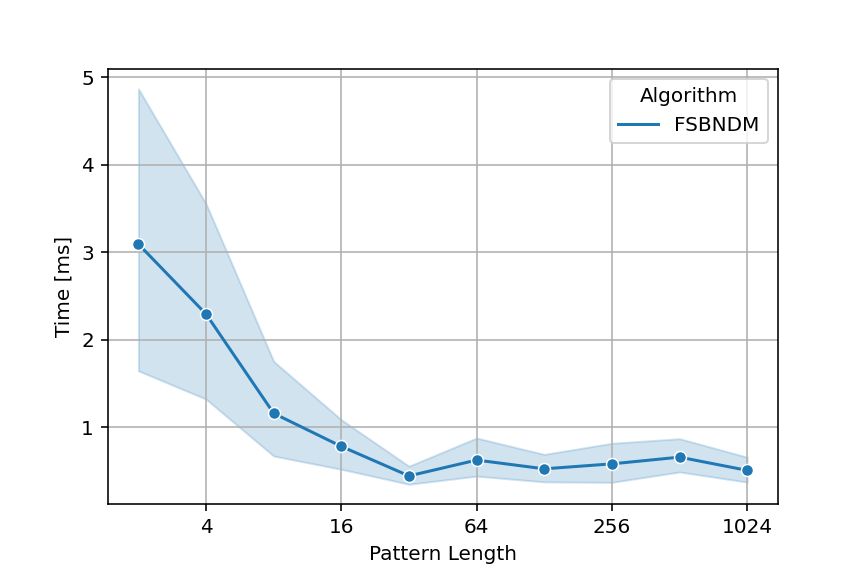

In [193]:
visualizer = set_up_main_panel() # The Entire Dashboard
watch_text_size = text_size_watcher() # Track text size Changes
trig_text_event() # Trigger text size event to have a default mid plot
watch_alphabet_size = alphabet_size_watcher() # Track alphabet_size
visualizer

In [15]:
def data_plots(data,ax):
    if data.size == 0:
        return ''

    # fig = Figure()
    # ax = fig.add_subplot()
    sns.lineplot(data=data,
                 x="Pattern Length",
                 y="Time [ms]",
                 hue='Algorithm',
                 ax=ax,
                 marker='o',
                 estimator='mean')
    ax.set_xscale('log', basex=2)
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.grid(True)

    # return fig

Saving figure algorithm performance chapter 4


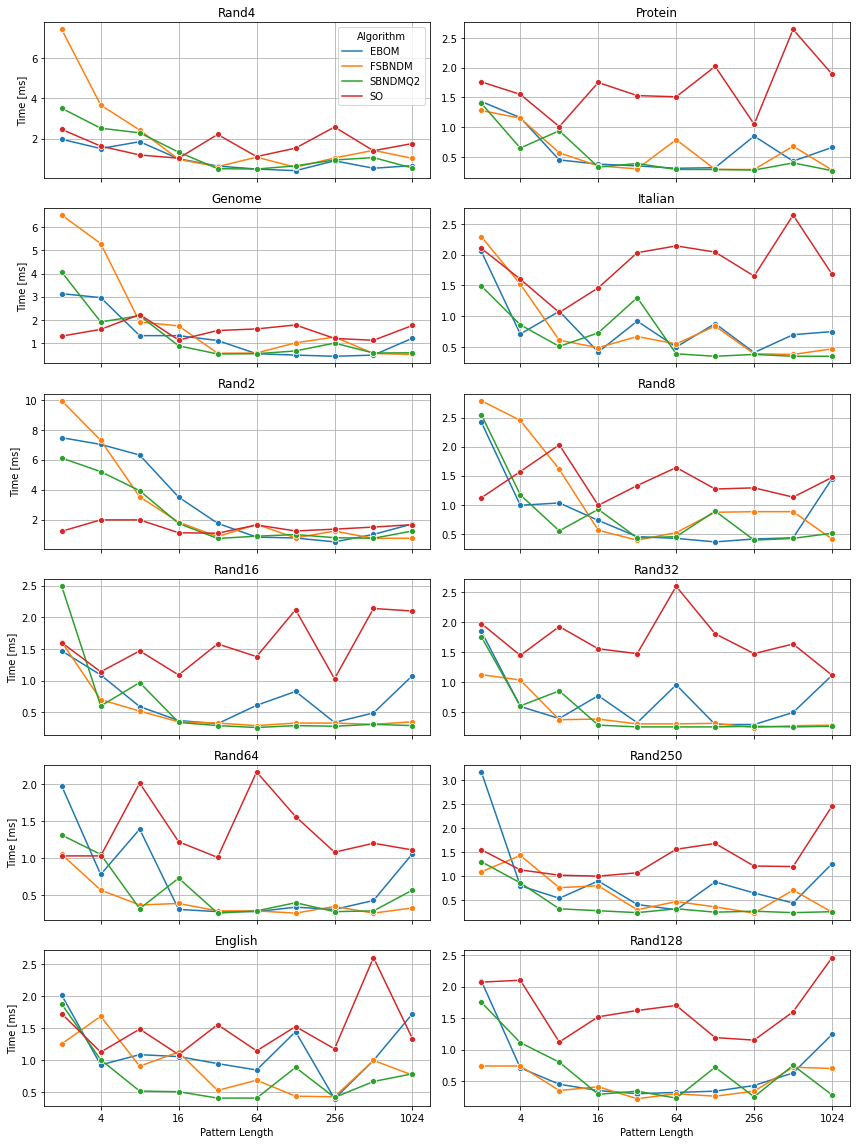

In [16]:
# Plots for different figures for reports [Top Four Algorithms]
fig,ax = plt.subplots(6,2,figsize=(12,16),sharex=False,sharey=False)
# Data for a category rand4, text size 1,algorithm SO,SBNDMQ2,EBOM,FSBNDM
algorithm = ['SO','SBNDMQ2','EBOM','FSBNDM']

# Rand4
category = ['rand4']
rand4 = matching_data.query('Algorithm in @algorithm & `Text Size [MB]`==1 &Category in @category')
data_plots(rand4,ax[0,0])
ax[0,0].set_title('Rand4',fontsize='12')
ax[0,0].set_xlabel('')
ax[0,0].tick_params(axis='x',labelbottom=False)

# protein
category = ['protein']
df = matching_data.query('Algorithm in @algorithm & `Text Size [MB]`==1 &Category in @category')
data_plots(df,ax[0,1])
ax[0,1].set_title('Protein',fontsize='12')
ax[0,1].tick_params(axis='x',labelbottom=False)
ax[0,1].set_xlabel('')
ax[0,1].set_ylabel('')
ax[0,1].get_legend().remove()

# genome
category = ['genome']
df = matching_data.query('Algorithm in @algorithm & `Text Size [MB]`==1 &Category in @category')
data_plots(df,ax[1,0])
ax[1,0].set_title('Genome',fontsize='12')
ax[1,0].tick_params(axis='x',labelbottom=False)
ax[1,0].set_xlabel('')
ax[1,0].get_legend().remove()

# italy
category = ['italianTexts']
df = matching_data.query('Algorithm in @algorithm & `Text Size [MB]`==1 &Category in @category')
data_plots(df,ax[1,1])
ax[1,1].set_title('Italian',fontsize='12')
ax[1,1].tick_params(axis='x',labelbottom=False)
ax[1,1].set_xlabel('')
ax[1,1].set_ylabel('')
ax[1,1].get_legend().remove()

# Rand2
category = ['rand2']
rand4 = matching_data.query('Algorithm in @algorithm & `Text Size [MB]`==1 &Category in @category')
data_plots(rand4,ax[2,0])
ax[2,0].set_title('Rand2',fontsize='12')
ax[2,0].set_xlabel('')
ax[2,0].get_legend().remove()
ax[2,0].tick_params(axis='x',labelbottom=False)

# Rand8
category = ['rand8']
df = matching_data.query('Algorithm in @algorithm & `Text Size [MB]`==1 &Category in @category')
data_plots(df,ax[2,1])
ax[2,1].set_title('Rand8',fontsize='12')
ax[2,1].set_xlabel('')
ax[2,1].set_ylabel('')
ax[2,1].get_legend().remove()
ax[2,1].tick_params(axis='x',labelbottom=False)

# Rand16
category = ['rand16']
rand4 = matching_data.query('Algorithm in @algorithm & `Text Size [MB]`==1 &Category in @category')
data_plots(rand4,ax[3,0])
ax[3,0].set_title('Rand16',fontsize='12')
ax[3,0].set_xlabel('')
ax[3,0].get_legend().remove()
ax[3,0].tick_params(axis='x',labelbottom=False)

# Rand32
category = ['rand32']
df = matching_data.query('Algorithm in @algorithm & `Text Size [MB]`==1 &Category in @category')
data_plots(df,ax[3,1])
ax[3,1].set_title('Rand32',fontsize='12')
ax[3,1].set_xlabel('')
ax[3,1].set_ylabel('')
ax[3,1].get_legend().remove()
ax[3,1].tick_params(axis='x',labelbottom=False)

# Rand64
category = ['rand64']
rand4 = matching_data.query('Algorithm in @algorithm & `Text Size [MB]`==1 &Category in @category')
data_plots(rand4,ax[4,0])
ax[4,0].set_title('Rand64',fontsize='12')
ax[4,0].set_xlabel('')
ax[4,0].get_legend().remove()
ax[4,0].tick_params(axis='x',labelbottom=False)

# Rand128
category = ['rand250']
df = matching_data.query('Algorithm in @algorithm & `Text Size [MB]`==1 &Category in @category')
data_plots(df,ax[4,1])
ax[4,1].set_title('Rand250',fontsize='12')
ax[4,1].set_xlabel('')
ax[4,1].set_ylabel('')
ax[4,1].get_legend().remove()
ax[4,1].tick_params(axis='x',labelbottom=False)

# english
category = ['englishTexts']
df = matching_data.query('Algorithm in @algorithm & `Text Size [MB]`==1 &Category in @category')
data_plots(df,ax[5,0])
ax[5,0].set_title('English',fontsize='12')
ax[5,0].get_legend().remove()

# rand128
category = ['rand128']
df = matching_data.query('Algorithm in @algorithm & `Text Size [MB]`==1 &Category in @category')
data_plots(df,ax[5,1])
ax[5,1].set_title('Rand128',fontsize='12')
ax[5,1].set_ylabel('')
ax[5,1].get_legend().remove()


save_fig('algorithm performance chapter 4')

## A closer look at the 🔝 four best performing algorithms.

We already know from the previous section that `FSBNDM`,`EBOM`,`SBNDMQ2`, and `SO`are the top 4 performer in terms of search completion time. While it might be difficult to investigate the algorithm performances for all cases, lets check few of the scenarios:-


1.   Strengths and Weaknesses of the top 4 best performing algorithms when the `text sizes` and `pattern length` are varied.
2.   Same as `1` but when corpus(`Category`) is changed instead of `text sizes`.



In [17]:
matching_data.columns

Index(['Category', 'Text Size [MB]', 'Pattern Length', 'Alphabet Size',
       'Time [ms]', 'Algorithm', 'Best Algo'],
      dtype='object')

In [18]:
from sklearn.preprocessing import OrdinalEncoder
best_only = matching_data[matching_data['Best Algo'].isna() == False]
cMap = OrdinalEncoder()
c = cMap.fit_transform(np.array(best_only['Best Algo']).reshape(-1,1))
cMap.categories_[0]

array(['AOSO2', 'BNDM', 'EBOM', 'FAOSO4', 'FJS', 'FS', 'FSBNDM', 'HOR',
       'LBNDM', 'RAITA', 'SBNDMQ2', 'SO', 'SSEF'], dtype=object)

In [19]:
X =best_only[['Pattern Length','Alphabet Size','Best Algo']].groupby(['Best Algo']).count()['Pattern Length']
best_only['size']=best_only['Best Algo'].apply(lambda a:X[a])

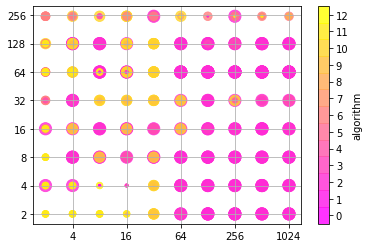

In [20]:
# fig = Figure(figsize=(10,20))
fig,ax = plt.subplots()
img = ax.scatter(best_only[['Pattern Length']].values, 
           best_only[['Alphabet Size']].values,
           c=c,
           cmap=plt.cm.get_cmap('spring', 13),
           s = best_only['size'].values,
           alpha = 0.8,
           lw = 0.8,
              )
# plt.matshow(best_only[['Pattern Length','Alphabet Size']],cmap=c)
plt.colorbar(img,ticks=range(13), label='algorithm')
ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=2)
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.grid(True)
img.set_clim(-0.5, 12.5)

### Strengths💹 and Weaknesses📉 of the top 4 best performing algorithms when the `text sizes` and `pattern length` varies.

| Column: text size, Row: pattern length, <font color='green'>Cell: best algorithm</font> |
| -- |


| | 1 | 2 | 4 | 5 | 6.8 | 8 | 16 | 32 | 64 | 128 |
| -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| 8 | FSBNDM | FSBNDM | FSBNDM | <font color='red'>**LBNDM**</font> | <font color='blue'>**FAOSO4**</font> | FSBNDM | FSBNDM | FSBNDM | FSBNDM | FSBNDM |
| 16 | FSBNDM | FSBNDM | FSBNDM | <font color='red'>**LBNDM**</font> | FSBNDM | FSBNDM | FSBNDM | FSBNDM | FSBNDM | FSBNDM |
| 32 | FSBNDM | FSBNDM | FSBNDM | FSBNDM | FSBNDM | FSBNDM | FSBNDM | FSBNDM | FSBNDM | FSBNDM |
| 64 | FSBNDM | FSBNDM | FSBNDM | FSBNDM | FSBNDM | FSBNDM | FSBNDM | <font color='red'>**LBNDM**</font> | FSBNDM | FSBNDM |
| 128 | FSBNDM | FSBNDM | FSBNDM | FSBNDM | FSBNDM | FSBNDM | FSBNDM | <font color='red'>**LBNDM**</font> | <font color='red'>**LBNDM**</font> | <font color='red'>**LBNDM**</font> |
| 256 | FSBNDM | FSBNDM | FSBNDM | <font color='red'>**LBNDM**</font> | <font color='red'>**LBNDM**</font> | <font color='blue'>**FAOSO4**</font> | <font color='red'>**LBNDM**</font> | <font color='red'>**LBNDM**</font> | <font color='red'>**LBNDM**</font> | <font color='red'>**LBNDM**</font> |

What we see in this table is that generally, the `FSBNDM` outperforms the rest of the algorithms especially when the `text size` is below `5`. Also it does better for all `text sizes` when the pattern length is `32`. We also observe other algorithms come into picture When `text size` is `5` and above. When the `pattern lengths` and `text sizes` are increased the FSBNDM seems to struggle while `LBNDM` excels but not entirely. Finally, `AOSO2` doesn't appear at this data summarization level. `FAOSO4` appears occasionally. Let's dig deeper to understand how these algorithms perform under different categories(corpuses). 


### Strengths💹 and Weaknesses📉 of the top 4 best performing algorithms when the `category` and `pattern length` varies.

| Row: category, Column: pattern length, cell: best algorithm, `text size = 1` |
| -- |

| | 8 | 16 | 32 | 64 | 128 | 256 |
| -- | -- | -- | -- | -- | -- | -- |
| rand2 | FSBNDM | FSBNDM | FSBNDM | FSBNDM | FSBNDM | FSBNDM |
| rand4 | <font color='green'>**AOSO2**</font> | <font color='blue'>**FAOSO4**</font> | <font color='blue'>**FAOSO4**</font> | <font color='blue'>**FAOSO4**</font> | <font color='blue'>**FAOSO4**</font> | FSBNDM |
| rand8 | FSBNDM | <font color='blue'>**FAOSO4**</font> | FSBNDM | <font color='blue'>**FAOSO4**</font> | <font color='red'>**LNDBM**</font> | <font color='red'>**LNDBM**</font> |
| rand16 | FSBNDM | FSBNDM | FSBNDM | FSBNDM | <font color='red'>**LNDBM**</font> | <font color='red'>**LNDBM**</font> |
| rand32 | FSBNDM | FSBNDM | FSBNDM | FSBNDM | FSBNDM | <font color='red'>**LNDBM**</font> |
| rand64 | FSBNDM | <font color='red'>**LNDBM**</font> | FSBNDM | FSBNDM | <font color='red'>**LNDBM**</font> | <font color='red'>**LNDBM**</font> |
| rand128 | FSBNDM | FSBNDM | FSBNDM | FSBNDM | <font color='red'>**LNDBM**</font> | <font color='red'>**LNDBM**</font> |
| rand250 | FSBNDM | FSBNDM | FSBNDM | <font color='red'>**LNDBM**</font> | FSBNDM | FSBNDM |
| protein | FSBNDM | <font color='blue'>**FAOSO4**</font> | <font color='red'>**LNDBM**</font> | FSBNDM | FSBNDM | <font color='blue'>**FAOSO4**</font> |
| genome | <font color='green'>**AOSO2**</font> | <font color='blue'>**FAOSO4**</font> | <font color='blue'>**FAOSO4**</font> | <font color='blue'>**FAOSO4**</font> | <font color='blue'>**FAOSO4**</font> | <font color='green'>**AOSO2**</font> |
| italian | FSBNDM | <font color='blue'>**FAOSO4**</font> | FSBNDM | <font color='red'>**LNDBM**</font> | <font color='red'>**LNDBM**</font> | <font color='red'>**LNDBM**</font> |
| english | <font color='green'>**AOSO2**</font> | FSBNDM | <font color='blue'>**FAOSO4**</font> | <font color='green'>**AOSO2**</font> | <font color='red'>**LNDBM**</font> | FSBNDM |

We can tell a few words about this setup. First, generally the `FSBNDM` does pretty well except when the `text categories` are `rand4, rand8, genome,italian, english` texts. Second, it looks like `FSBNDM` the best performing algorithm does not understand `genome` texts at all. Third, the algorithms performance is almost balanced when the corpuses is from `english` texts. `FAOSO4` does well when the text categories are `rand4` and `genome` perhaps we can also say when `alphabet size` is `4`? because both these two have an alphabet size of `4`. Fourth, `LNDBM` performs quite well when the `pattern length` is high. Fifth, `AOSO2` the least performing algorithm among the four appears this time, it doesn't have any specific pattern. Finally, as you may already have imagined, it's not that simple to say this algorithm does better than the rest all depend on the provided circumstances. For example in our case we could have chosen to implement `FSBNDM` but what if we are searching on genome database for example, it could consume resources for long time unnecessary while we could have implemented `FAOSO4` instead. What if you seat back and let the simple tool help you decide in no time which algorithm to implement or to be run  based on the queries at hand?. Perfect! this table provided a glimpse on the need of that tool, because the algorithms behave differently under different conditions.

## Time to play Violin 🎻

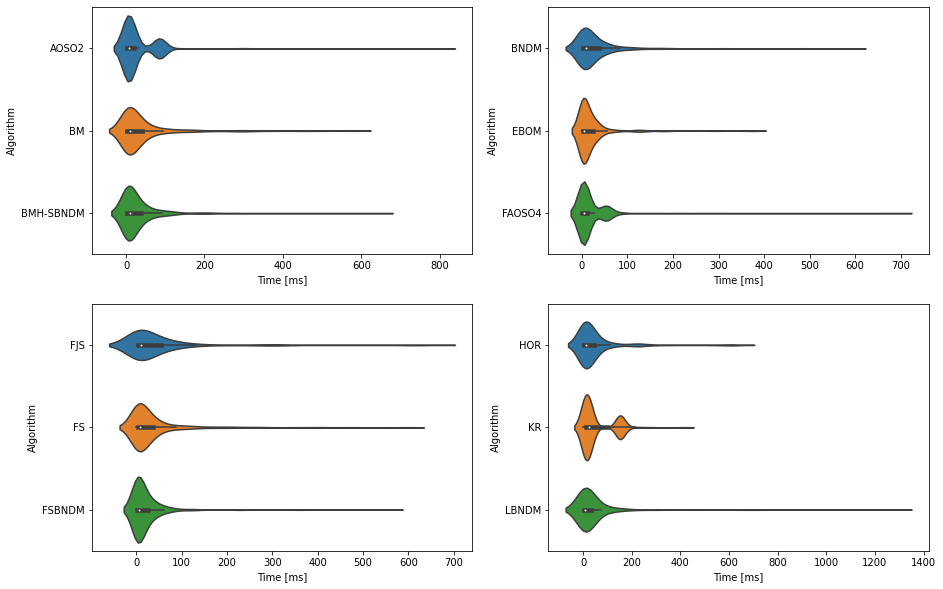

In [21]:
fig,ax = plt.subplots(2,2,figsize=(15,10))
ax = ax.flatten()
algos = matching_data['Algorithm'].unique()
# Total algo in play: 13
orders = algos.reshape(6,3)
orders = orders.tolist()
# The last algo included
#orders[-1] += [algos[-1]]
for i in range(len(ax)):
    sns.violinplot(data=matching_data, 
               x='Time [ms]',
               y="Algorithm",
               order=orders[i],
               ax=ax[i],
               )


Most of the algorithms are centered across the median with a very little distribution when time increases. Remember `BM`, `KR` and `TW` were not among the best algorithms? We can also observe from the violin plot that their tail extends further than their counterparts.

# Key take aways


1.   The algorithm distributions are right-skewed.[here](#scrollTo=TXug62-xzEu1) and [here](#scrollTo=hHjgYsbUWuHq)
2.   Attributes exhibit different scaling and there is a possibility to [apply log scales](#scrollTo=LSXqjPksi5uZ), etc.
3.   The time attribute immitates an [exponential](#scrollTo=7Yn8F8rp3DFb) distribution.
4.   `BM`,`KR` and `TW` didn't [win](#scrollTo=UvvpuD5KApeX) in either of the test experiments.
5.   Smart dataset is [uneven](#scrollTo=UvvpuD5KApeX) distributed. We must be careful when we split the data and choose the performance metrics.
6.   In most cases, `FSBNDM` algorithm seems to perform better than it's rivals especially when the corpus is [random](#scrollTo=QOyPhcUneE2B).
7.   The best algorithm `FSBNDM` seems not to quickly understand `genome` texts and competes [fairly](#scrollTo=QOyPhcUneE2B) with its rivals for the corpuses which are not random.
8.   The `LBNDM` second best algorithm performs better for higher [pattern](#scrollTo=QOyPhcUneE2B) lengths.
9.   The `FAOSO4` seems [better](#scrollTo=QOyPhcUneE2B) for `genome` and `rand4`



# Feature Engineering

Before marching forward, we can create additional features from the pre-existing ones. We have `time` and `text size` combining these two we may calculate the algorithm speeds using the formula: `speed = text size / time`

In [22]:
# speed in GB/s
matching_data['speed'] = (matching_data['Text Size [MB]'] / matching_data['Time [ms]'])*1000/1024

# Modeling

In [23]:
## Import important libraries
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit

## Data Checking

This time around we take a look at the actual data points for model development by simply ommiting the null from the `Best Algo` column.

In [24]:
smart = matching_data[matching_data['Best Algo'].notnull()].reset_index()
smart.drop('index',axis=1,inplace=True)
smart.describe()

,Text Size [MB],Pattern Length,Alphabet Size,Time [ms],speed
count,488.000000,488.000000,488.000000,488.000000,488.000000
mean,16.245902,207.803279,74.479508,13.398689,1.899483
std,19.560389,315.583216,71.055691,21.253500,0.959434
min,1.000000,2.000000,2.000000,0.220000,0.464764
25%,1.000000,8.000000,14.000000,1.280000,1.169118
50%,5.000000,64.000000,64.000000,4.225000,1.860119
75%,10.000000,256.000000,128.000000,20.305000,2.441406
max,50.000000,1024.000000,250.000000,105.060000,4.438920


## Train and Test set split


Saving figure speed distribution


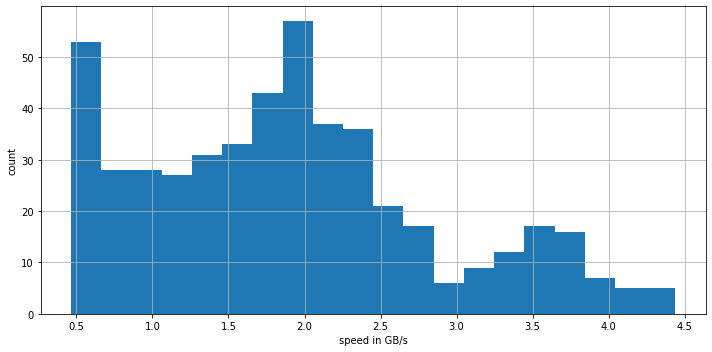

In [25]:
_=smart['speed'].hist(bins=20, figsize=(10,5))
plt.ylabel('count')
plt.xlabel('speed in GB/s')
save_fig('speed distribution')

In [26]:
# New attribute, to be removed after data split
# bins=[0.25,0.5,1.5,2.5,3.5,4.5,np.inf]
# [0.25,1,1.75,2.5,3.5,np.inf]
smart['speed_dist'] = pd.cut(smart['speed'], 
                            bins=[0.25,0.8,2,np.inf],
                            labels=[1,2,3])

### Random sampling

Random sampling works by dividing randomly the dataset into train and test set. This method normally breaks when the function is reloaded. We run into a risk that all the test samples would likely be seen into the training set. One way to fix this is to run the function once and save the test data somewhere and load it everytime you want to run the program. Another way is to seed the function performing the splitting operation however this breaks again when you have an updated dataset. Another approach is to find a unique identifier (for example a row index id) for each instance and split based on this identifier, one disadvantage of this approach is that everytime you have new data samples they should be appended at the end of the current dataset. If we have a huge dataset it's ideal to apply random sampling method. In this section we will deploy the scikit-learn train-test-split method to split our dataset.

In [27]:
# Purely Random Splitting
rnd_train, rnd_test = train_test_split(smart,test_size=0.3,random_state=2022)

### Stratified sampling-[TODO]Update content

Stratified sampling works by dividing the dataset into smaller homogeneous groups called `strata` and make sure there is a fair representations of the samples between test and train sets especially when the dataset is small. For example, we know that the algorithm speed is a key factor into rulling out the best algorithm. So we select `speed` attribute to demonstrate even distribution and minimize sampling bias. First we need to create a new attribute `speed_dist` and cut it into bins `[0.5,1.5,2.5,3.5,4.5,np.inf]` plus generate fictious entries `[1,2,3,4,5]` which would mean everywhere we find the speed between `0.5` and `1.5` we label it as `1`, and so on. Have a look at histogram below.

Saving figure speed distribution label


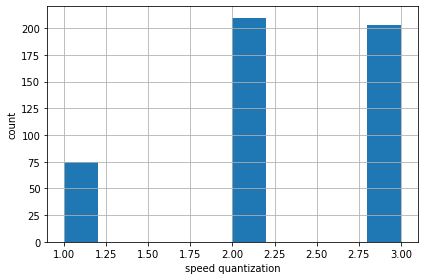

In [28]:
# Speed distribution
_=smart['speed_dist'].hist()
plt.ylabel('count')
plt.xlabel('speed quantization')
save_fig('speed distribution label')

In [29]:
# smart[smart['speed_dist'].isna()==True]
smart.columns

Index(['Category', 'Text Size [MB]', 'Pattern Length', 'Alphabet Size',
       'Time [ms]', 'Algorithm', 'Best Algo', 'speed', 'speed_dist'],
      dtype='object')

In [30]:
def strataShuffle():
    split = StratifiedShuffleSplit(n_splits=1,test_size=0.3,random_state=2022)
    for trn_index,tst_index in split.split(smart,smart['speed_dist']):
        strat_train_set = smart.loc[trn_index]
        strat_test_set = smart.loc[tst_index]
    return strat_train_set,strat_test_set

In [31]:
strat_train,strat_test = strataShuffle()

In [32]:
df_test = pd.DataFrame(data=strat_test, columns=smart.columns)
df_test['Best Algo'].value_counts()

EBOM       46
SBNDMQ2    35
FSBNDM     19
FJS        13
SO         11
LBNDM       9
FAOSO4      3
FS          3
AOSO2       3
BNDM        2
SSEF        1
RAITA       1
HOR         1
Name: Best Algo, dtype: int64

In [33]:
df_train = pd.DataFrame(data=strat_train, columns=smart.columns)
df_train['Best Algo'].value_counts()

EBOM       106
SBNDMQ2     76
FSBNDM      56
SO          34
LBNDM       30
FJS         15
FAOSO4       7
SSEF         5
AOSO2        3
RAITA        3
FS           3
BNDM         2
HOR          1
Name: Best Algo, dtype: int64

In [34]:
smart['Best Algo'].value_counts() #HOR,AOSO2

EBOM       152
SBNDMQ2    111
FSBNDM      75
SO          45
LBNDM       39
FJS         28
FAOSO4      10
AOSO2        6
FS           6
SSEF         6
RAITA        4
BNDM         4
HOR          2
Name: Best Algo, dtype: int64

In [35]:
smart.query("`Best Algo`=='FAOSO4'")

,Category,Text Size [MB],Pattern Length,Alphabet Size,Time [ms],Algorithm,Best Algo,speed,speed_dist
47,rand4,1.0,16,4.0,0.67,FAOSO4,FAOSO4,1.457556,2
48,rand4,1.0,256,4.0,0.84,FAOSO4,FAOSO4,1.162574,2
55,rand4,5.0,16,4.0,5.22,FAOSO4,FAOSO4,0.935405,2
56,rand4,5.0,32,4.0,3.95,FAOSO4,FAOSO4,1.236155,2
68,rand4,10.0,16,4.0,11.46,FAOSO4,FAOSO4,0.852149,2
78,rand4,50.0,16,4.0,55.13,FAOSO4,FAOSO4,0.885691,2
298,rand250,5.0,8,250.0,2.97,FAOSO4,FAOSO4,1.644045,2
383,genome,5.0,16,64.0,5.92,FAOSO4,FAOSO4,0.824799,2
393,genome,10.0,16,64.0,11.19,FAOSO4,FAOSO4,0.872710,2
404,genome,50.0,16,64.0,55.23,FAOSO4,FAOSO4,0.884087,2


### Comparisons and splitting the dataset

In [36]:
def proportion(data):
    return data['speed_dist'].value_counts()/len(data)

df = {'Overall':proportion(smart),
      'Stratified':proportion(strat_test),
      'Random':proportion(rnd_test)}

comparison_df = pd.DataFrame(df).sort_index()
comparison_df['Stratified_%error'] = ((comparison_df['Stratified']-comparison_df['Overall'])/(comparison_df['Overall']))*100
comparison_df['Random_%error'] = ((comparison_df['Random']-comparison_df['Overall'])/(comparison_df['Overall']))*100
comparison_df

,Overall,Stratified,Random,Stratified_%error,Random_%error
1,0.153689,0.156463,0.108844,1.804989,-29.179138
2,0.430328,0.428571,0.489796,-0.408163,13.819242
3,0.415984,0.414966,0.401361,-0.244630,-3.515298


In [37]:
comparison_df.to_csv('comparisons strat vs random.csv')

Saving figure stratifiedVSrandom


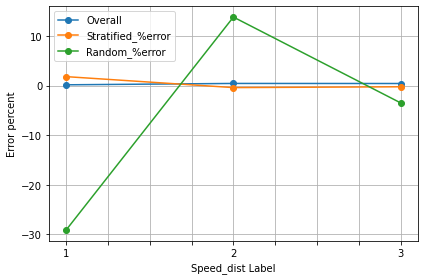

In [38]:
_=comparison_df[['Overall','Stratified_%error','Random_%error']].plot(kind='line',marker='o')
plt.xlabel("Speed_dist Label")
plt.ylabel('Error percent')
plt.grid()
# plt.title("Random and stratified test set divergence wrt overall dataset")
save_fig('stratifiedVSrandom')

We observe that the test set generated by stratified sampling has speed distribution proportions almost identical to those in a full dataset (Overall) while the test set generated by the random sampling highly diverge from the ground truth. Thus we will adopt stratified sampling to split our dataset. Next, we will drop the `speed_dist` as it has no use moving forward.

In [39]:
for data in (strat_train,strat_test):
    data.drop('speed_dist',axis=1, inplace=True)

In [40]:
np.unique(strat_test['Best Algo'])

array(['AOSO2', 'BNDM', 'EBOM', 'FAOSO4', 'FJS', 'FS', 'FSBNDM', 'HOR',
       'LBNDM', 'RAITA', 'SBNDMQ2', 'SO', 'SSEF'], dtype=object)

## Looking for correlation
We compute the pearson correlation between numerical attribute pairs.

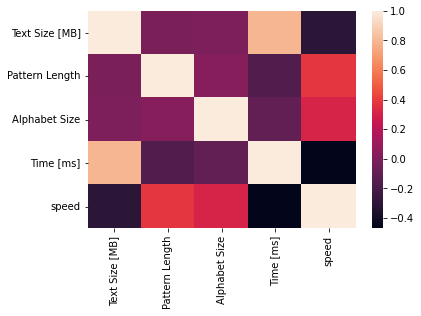

In [41]:
corr_matrix = smart.corr()
corr_matrix['Time [ms]']
sns.heatmap(corr_matrix)

## Data clean up and transformation


### Dataset preprocessing pipeline for numerical features.

That's right we did add the speed during feature engineering step, however its a common practice to build a custom transformer to do just that. This transformation will later be part of an end to end transformation pipeline. We could have done it earlier but okay we will drop the `speed` feature and re-add using a novice technique. I promise not to touch the `strat_test` again until we are done with model development.

In [42]:
# Later take a look here, comment out this code
for data in (strat_train,strat_test):
    data.drop('speed',axis=1, inplace=True)


Now `Algorithm` and `Best Algo` attributes looks similar, we can delete one of those. We delete `Best Algo`.

In [43]:
smart_train = strat_train.drop('Best Algo',axis=1)

Next, we set aside the training features and label. It is not necessary that they exhibit the same transformations.

In [44]:
smart_train.drop('Algorithm',axis=1,inplace=True) # Remove Algorithm from features its a label
smart_train_labels = strat_train['Algorithm'].copy()

Then, we remove categorical attributes from the train set as we can't scale on them.

In [45]:
cat = ['Category']
smart_train_num = smart_train.drop(cat,axis=1,)

In [46]:
smart_train_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 341 entries, 12 to 293
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Text Size [MB]  341 non-null    float64
 1   Pattern Length  341 non-null    int64  
 2   Alphabet Size   341 non-null    float64
 3   Time [ms]       341 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 13.3 KB


In [47]:
smart_train_num

,Text Size [MB],Pattern Length,Alphabet Size,Time [ms]
12,5.0,128,2.0,3.93
292,1.0,32,250.0,0.24
246,1.0,8,128.0,0.35
50,1.0,64,4.0,0.49
217,5.0,2,64.0,7.25
...,...,...,...,...
34,50.0,512,2.0,34.14
220,5.0,32,64.0,2.12
239,50.0,4,64.0,46.08
314,10.0,1024,250.0,2.35


Our dataset seems to contain no missing entries, thus imputation may not be significant. Next, we decide to add more features. We define the custom transformer to perform this job. The class extends the `base` class from scikit-learn library. 

In [48]:
from sklearn.base import BaseEstimator, TransformerMixin
txt_size_index,time_index = [smart_train_num.columns.get_loc(col) for col in ['Text Size [MB]','Time [ms]']]
class AttributesAdder(BaseEstimator,TransformerMixin):
    def __init__(self,addSpeed=False,dropTime=True):
        self.addSpeed = addSpeed
        self.dropTime = dropTime
    
    def fit(self, X, y=None):
        return self

    def transform(self,X):
        if self.addSpeed:
            speed = (X.iloc[:,txt_size_index] / X.iloc[:,time_index]) * 1000/1024
            return np.c_[X,speed]
        if self.dropTime:
            return np.delete(X.values,time_index,1)
        return X

We noted previously that the samples are all positive and that they are right-skewed. In this case we may try to implement a log transformation. Two advantages here, we will be less affected by outliers and also the dataset could be normally distributed which is an important recipe to Machine Learning models. We will use scikit-Learn `FunctionTransformer` class to apply `np.log1p` transformation to the dataset. We could also have decided to implement our own scaling function as per above template class `AttributesAdder`

In [49]:
from sklearn.preprocessing import FunctionTransformer
log_scaling = FunctionTransformer(func=np.log1p, validate=True)

Almost done with numerical data processing steps, Let's combine the two transformations we just did into one pipe. Ok, we make use of the `Pipeline` class from scikit-learn.

In [50]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
numerical_pipe = Pipeline([
                           ('add_drop_attributes',AttributesAdder()),
                           ('log_scaler',FunctionTransformer(func=np.log1p, validate=True))
])


Let's check how the numerical data looks like, before and after transformation.

In [51]:
smart_train_num_tr = numerical_pipe.fit_transform(smart_train_num)
smart_train_num_tr

array([[1.79175947, 4.8598124 , 1.09861229],
       [0.69314718, 3.49650756, 5.52545294],
       [0.69314718, 2.19722458, 4.8598124 ],
       ...,
       [3.93182563, 1.60943791, 4.17438727],
       [2.39789527, 6.93244789, 5.52545294],
       [0.69314718, 4.17438727, 5.52545294]])

Saving figure scaling


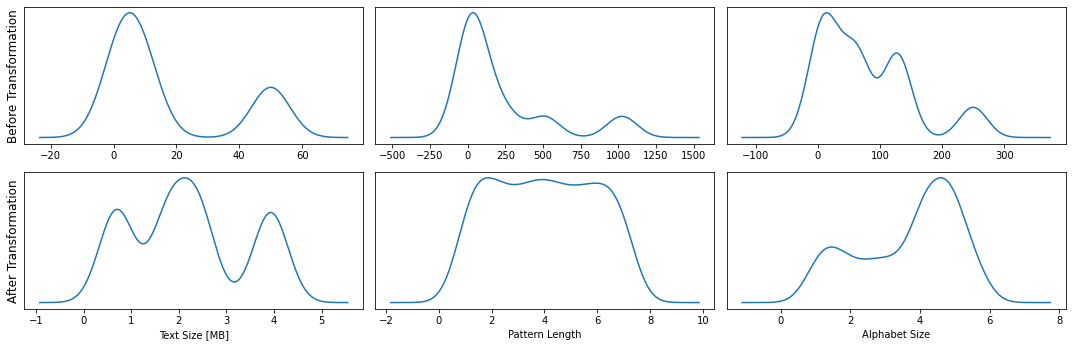

In [52]:
# Plots

# num = ['Text Size [MB]','Pattern Length','Alphabet Size','Time [ms]','speed [GB/s]']
num = ['Text Size [MB]','Pattern Length','Alphabet Size']
smart_train_num_tmp = AttributesAdder().fit_transform(smart_train_num)
smart_train_num_tr_df = pd.DataFrame(smart_train_num_tr,columns=num)
smart_train_num_tmp_df = pd.DataFrame(smart_train_num_tmp,columns=num)
#print(smart_train_num_tmp)
fig,ax = plt.subplots(2,3,figsize=(15,5))
ax = ax.flatten()

for i in range(len(ax)):
    
    if (i<3):
        # Untransformed plots: First row
        smart_train_num_tmp_df[num[i]].plot(kind='kde',ax=ax[i])
        ax[i].set_ylabel('')
    else:
        # Transformed Plots: second row
        smart_train_num_tr_df[num[i-3]].plot(kind='kde',ax=ax[i])
        ax[i].set_xlabel(num[i-3])
        ax[i].set_ylabel('')
        
ax[0].set_ylabel('Before Transformation',fontsize='12')
ax[3].set_ylabel('After Transformation',fontsize='12')
for axix in ax:
    axix.tick_params(
        axis='y',
        which='both',
        left=False,
        labelleft=False,
    )
save_fig('scaling')

Looking at the plots (x-axis and the shape) we notice the scaling effect especially when the attributes are skewed. The log scale did try to normalize the data to follow gaussian normal distribution. There are quite a number of scaling options available, to mention a few of them: Min-Max, standard, robust, and power and log based scalers. We will revisit some of those options if need be as model performance could be affected with the scaler choice which in deed depends on the dataset at hand.

## Dataset preprocessing pipeline for categorical features.

In the previous section we developed a pipeline to first add additional attributes and second perform scaling on numerical features. In this section we try to encode the text enchriched `category` attribute. We can consider Label or one hot encoding methods. With the classical label encoder the categories are firstly sorted (not necessary though, you can create a custom one with your own rules) in ascending order and then each assigned an ordinal number from `0` to `n-1` where `n` is the total number of unique classes/categories available. This might not be a good approach into features representation as it might happen that a machine learning algorithm think that `0` and `1` are related to each other because they are close to each other, while in reality perhaps class `0` has a close relationship with class `10` for instance. The representation might be good in some use cases such as rating a product, it's true that 0 is related to 1 etc. In contrast, one hot encoders typically assigns `1` (hot) to this particular class and `0` (cold) to the rest. These additional attributes (zeros) are sometimes refered as dummy attributes. So all have equal weight in this case a machine learning algorithm won't make up things.

In this section apart from adopting a one-hot encoder from sklearn library, we also adopt `columnTransformer` class which helps us to apply transformations to individual columns we specify. We can also `drop` or `passthrough` columns we don't want to apply transformations. Let's see how it goes. Remember we split the dataset to train and test sets?, that's right, but we real messed with the copy of it. But now we want after data split, we hit straight to pipelines all done in a seemless way as below steps:-

1.   Drop unrequired attributes (`Best Algo`): automatically dropped
2.   Drop a label column (`Algorithm`): automatically dropped
3.   Drop Categorical feature (`Category`): automatically dropped
4.   Apply AttributesAdder transformer to add features (`speed`)
5.   Apply feature scaling using the `FunctionTransformer`
6.   Apply one-hot encoding to categorical features

That's it, features are ready for machine learning algorithms consumption. Later, we will take care of the label column, its categorical perhaps ordinal encoding will do the trick here and since we are not aiming at developing a `multi-output model` we won't do a one-hot encoding.

In [53]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

num_attributes = ['Text Size [MB]','Pattern Length','Alphabet Size','Time [ms]']
cat_attributes = ['Category']

features_full_pipeline = ColumnTransformer([
                                            ("num_attr",numerical_pipe,num_attributes),
                                            ("cat_attr",OneHotEncoder(),cat_attributes),
])

In [54]:
smart_features = features_full_pipeline.fit_transform(strat_train)

In [55]:
smart_features.shape

(341, 15)

In [56]:
# features_full_pipeline.transformers[1]


One last thing, Let's encode the smart dataset labels.

In [57]:
from sklearn.preprocessing import OrdinalEncoder

labels_full_pipeline = Pipeline([
                         ('labels',OrdinalEncoder())
])

smart_labels = labels_full_pipeline.fit_transform(strat_train['Algorithm'].values.reshape(-1,1))

In [58]:
smart_labels.shape

(341, 1)

In [59]:
labels_full_pipeline['labels'].categories_

[array(['AOSO2', 'BNDM', 'EBOM', 'FAOSO4', 'FJS', 'FS', 'FSBNDM', 'HOR',
        'LBNDM', 'RAITA', 'SBNDMQ2', 'SO', 'SSEF'], dtype=object)]

## How do algorithm separate from each other.
Let us check how distant the algorithms are from each other using PCA.

In [60]:
smart_features
smart_features.toarray().shape

(341, 15)

In [61]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
t_features = pca.fit_transform(smart_features.toarray())
t_features.shape

(341, 2)

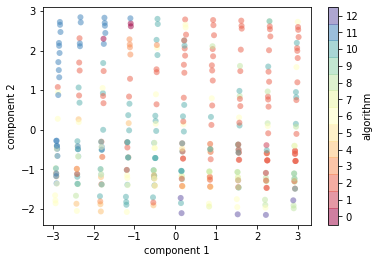

In [62]:
fig,ax = plt.subplots()
img=ax.scatter(t_features[:, 0], t_features[:, 1],
            c=smart_labels, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 13))
plt.xlabel('component 1')
plt.ylabel('component 2')
img.set_clim(-0.5, 12.5)
plt.colorbar(img,ticks=range(13), label='algorithm')
# plt.colorbar();

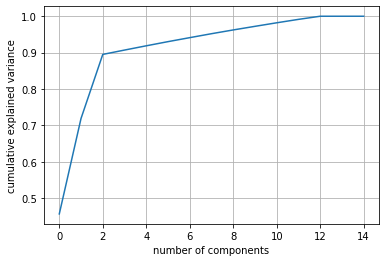

In [63]:
pca = PCA().fit(smart_features.toarray())
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.grid()

## Baseline Model a.k.a dumb model ---> To be revisited

In this section we start the model development journey by creating the baseline model. We develop a binary model to state whether this is a specified class or not and then extend the model for multi-class classification using OvR (One vs the Rest) principles. For the OvR, we will use a built in class in scikit-learn `OnevsRestClassifier`. What a Dumb classifier does is assuming that any data point to be predicted belongs to me (this particular class specified).

In [64]:
class DumbXClassifier(BaseEstimator):

    def fit(self,X,y=None):
        return self

    def predict(self,X):
        return np.ones((len(X),1),dtype=bool)
    # TODO: re-implement   
    def predict_proba(self,X):
        probs = np.zeros((len(X),2))
        probs[:,1] = 1
        return probs

In [65]:
from sklearn.model_selection import cross_val_score,cross_val_predict

X_train = smart_features.copy()
y_train = smart_labels.copy()
y_train_2 = (smart_labels == 2.0) # predict class 2/EBOM or not.

cross_val_score(DumbXClassifier(),X_train,y_train_2,cv=2,scoring='accuracy')

array([nan, nan])

In [66]:
# dc = DumbXClassifier().fit(X_train,y_train_2)
# dc.predict(X_train)
y_train_2.size

341

In [67]:
dumb = np.count_nonzero(y_train_2)/y_train_2.size
print(dumb)

0.31085043988269795


In [68]:
# from sklearn.multiclass import OneVsRestClassifier
# dumb_clf = OneVsRestClassifier(DumbXClassifier())
# cross_val_score(dumb_clf,X_train,y_train,cv=2,scoring='accuracy')

## Experiments on several ML algorithms using scikit-Learn library

### Quick check on possible base algorithms without tuning

#### Logistic Regression

In [69]:
from sklearn.linear_model import LogisticRegression
lr_train_base = cross_val_score(LogisticRegression(),X_train,y_train,cv=4,scoring='accuracy').mean()
print(lr_train_base)

0.5160738714090287


#### Random Forest


In [70]:
# Baseline Model
from sklearn.ensemble import RandomForestClassifier
rf_base = cross_val_score(RandomForestClassifier(),X_train,y_train,cv=4,scoring='accuracy').mean()
print(rf_base)

0.4633036935704515


#### SVC

In [71]:
from sklearn.svm import SVC
svc_base = cross_val_score(SVC(),X_train,y_train,cv=4,scoring='accuracy').mean()
print(svc_base)

0.4927154582763338


A closer look at SVC, Hyperparameter tuning using Randomized Grid Search. We are going to tune parameters to find out the best combination namely:- 


*   C -  Inverse of regularization
*   Kernel - A way to add more features
*   gamma - Incase of  Gaussian Radial Basis Function (RBF),Poly and Sigmoid.



In [72]:
from sklearn.model_selection import RandomizedSearchCV

# params = [
#           {'C':10**np.arange(0,10),'kernel':['poly','rbf','sigmoid'],'gamma':np.random.uniform(0,10,size=(10,))},
# ]

# random_grid_search = RandomizedSearchCV(
#     SVC(),
#     params,
#     cv=3,
#     scoring='accuracy',
#     n_iter=100,
#     return_train_score=True
#     )
# random_grid_search.fit(X_train,y_train)

In [73]:
# random_grid_search.best_params_

In [74]:
# random_grid_search.best_estimator_

In [75]:
# rcvres = random_grid_search.cv_results_
# for mean_score,param in zip(rcvres["mean_test_score"],rcvres['params']):
#     print(mean_score)

#### SDG

In [76]:
from sklearn.linear_model import SGDClassifier
cross_val_score(SGDClassifier(),X_train,y_train,cv=3,scoring='accuracy').mean()

0.3344977487967707

#### XGBOOST

In [77]:
from xgboost import XGBClassifier
xgboost_base = cross_val_score(XGBClassifier(),X_train,y_train,cv=4,scoring='accuracy').mean()
print(xgboost_base)

0.5190834473324213


Saving figure baseline


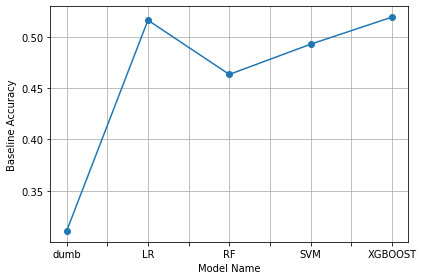

In [78]:
# Combine Base Results into a DataFrame

base_results = {
    'dumb':[dumb],
    'LR':[lr_train_base],
    'RF':[rf_base],
    'SVM':[svc_base],
    'XGBOOST':[xgboost_base]
}

base_df = pd.DataFrame(base_results)
base_df = base_df.T
base_df.columns=['Train Base Accuracy Performance']
_=base_df.plot(kind='line', marker='o')
plt.grid()
plt.legend().remove()
plt.ylabel('Baseline Accuracy')
plt.xlabel('Model Name')
save_fig('baseline')

In [79]:
bas_df = base_df.reset_index()
bas_df.columns=['model','base performance']
bas_df

,model,base performance
0,dumb,0.310850
1,LR,0.516074
2,RF,0.463304
3,SVM,0.492715
4,XGBOOST,0.519083


In [80]:
# !pip freeze
# !pip install matplotlib==3.2.2
#!pip install -U matplotlib

Saving figure base_performance_2


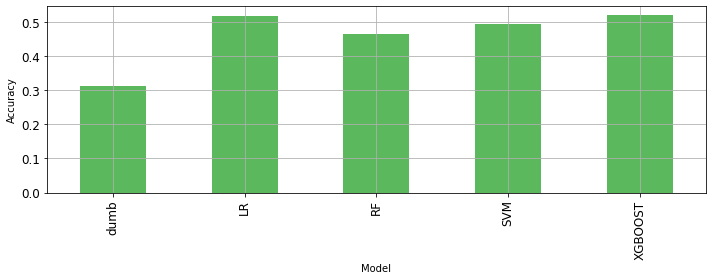

In [81]:
# Bar plot
# ax = sns.barplot(x='model', y='base performance', data=bas_df)
# ax.bar_label(ax.containers[0],fmt='%.4g',padding=0)
ax=base_df.plot(kind='bar',stacked=True, color=['#5cb85c'],figsize=(10, 4),ylabel='Accuracy',
                xlabel='Model',fontsize='12')
plt.tight_layout()
ax.get_legend().remove()
plt.grid()
save_fig('base_performance_2')

#### A Closer look at XGBOOST
In this section we try to optimize the XGBOOST algorithm by tuning its parameters.

In [82]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score
def fit_model(estimator,x_train,y_train,allowCV=True,n_fold=4,early_stop_round=50):

    if allowCV:
        params = estimator.get_xgb_params()
        train = xgb.DMatrix(x_train,label=y_train)
        results = xgb.cv(params,
                         train,
                         num_boost_round=estimator.get_params()['n_estimators'],
                         nfold=n_fold,
                         metrics='mlogloss',
                         early_stopping_rounds=early_stop_round,
                        verbose_eval=1
                         )
        estimator.set_params(n_estimators=results.shape[0])
    
    # Fit the data
    estimator.fit(x_train,y_train,eval_metric='mlogloss')

    # Prediction
    prediction_train = estimator.predict(x_train)
    predict_proba_train = estimator.predict_proba(x_train)[:,1]
    # print(predict_proba_train)
    # Report
    print("Accuracy : %.4g" % accuracy_score(y_train, prediction_train))
    # print("AUC Score (train): %f" % roc_auc_score(y_train, predict_proba_train))

    # imp_feat = pd.Series(estimator.booster().get_fscore()).sort_values(ascending=False)
    # print(imp_feat)
    #imp_feat.plot(kind='bar', title='Feature Importances')
    #plt.ylabel('Feature Importance Score')



1. We try to estimate the boosting parameters by fixing some other parameters. At this step we take the default `eta=0.1` and try to find the maximum number of estimators using cross validation. These initial params will be tuned afterwards.

In [83]:
# # Estimate number of estimators for high learning rate
# xgb1 = XGBClassifier(
#         learning_rate =0.1,
#         n_estimators=1000,
#         max_depth=5,
#         min_child_weight=1,
#         gamma=0,
#         subsample=0.8,
#         colsample_bytree=0.8,
#         objective= 'multi:softprob',
#         nthread=4,
#         scale_pos_weight=1,
#         seed=2022,
#         num_class=13,
#         verbosity=0)
# fit_model(xgb1, X_train, y_train)

We observe that after 92 iterations (`~n_estimators`) the model converges.

2. Lets tune the maximum depth and minimum child weight.
Proposed ranges: 


*   Max_depth `~3-10`
*   Min_child_weight: trade-off between under and overfitting



In [84]:
# from sklearn.model_selection import GridSearchCV
# params2 = {'max_depth':range(3,11,2),
#            'min_child_weight':range(1,6,2),
#            }
# # n_estimator changed to 92 as found above
# xgb2 = XGBClassifier(
#         learning_rate =0.1,
#         n_estimators=100,
#         max_depth=5,
#         min_child_weight=1,
#         gamma=0,
#         subsample=0.8,
#         colsample_bytree=0.8,
#         objective= 'multi:softprob',
#         nthread=4,
#         scale_pos_weight=1,
#         seed=2022,
#         num_class=13,
#         verbosity=0)

# grd2 = GridSearchCV(estimator=xgb2,
#                     param_grid=params2,
#                     scoring='accuracy',
#                     n_jobs=4,
#                     cv=4)
# grd2.fit(X_train,
#          y_train)
# grd2.cv_results_['mean_test_score'],grd2.best_params_,grd2.best_score_

Next, Let's search around 3 and 1 to find the optimum results

In [85]:
# params3 = {'max_depth':[2,3,4],
#           'min_child_weight':[0,1,2]}
# grd3 = GridSearchCV(estimator=xgb2,
#                     param_grid=params3,
#                     scoring='accuracy',
#                     n_jobs=4,
#                     cv=4)

# grd3.fit(X_train,
#          y_train)
# grd3.cv_results_['mean_test_score'],grd3.best_params_,grd3.best_score_

In [86]:
# xgb2 = XGBClassifier(
#         learning_rate =0.1,
#         n_estimators=100,
#         max_depth=3,
#         min_child_weight=2,
#         gamma=0,
#         subsample=0.8,
#         colsample_bytree=0.8,
#         objective= 'multi:softprob',
#         nthread=4,
#         scale_pos_weight=1,
#         seed=2022,
#         num_class=13,
#         verbosity=0)
# cross_val_score(xgb2,X_train,y_train,cv=4,scoring='accuracy').mean()

In [87]:
# # Min child weight above 4?
# params4 = {
#           'min_child_weight':[5,6,7,8]}
# grd4 = GridSearchCV(estimator=xgb2,
#                     param_grid=params4,
#                     scoring='accuracy',
#                     n_jobs=4,
#                     cv=4)

# grd4.fit(X_train,
#          y_train)
# grd4.cv_results_['mean_test_score'],grd4.best_params_,grd4.best_score_


3. Let's tune gamma using the previous established parameters i.e `min_child_weight=2, max_depth=3, n_estimators=100`

In [88]:
# params5 = {'gamma':np.arange(0,5,1)/10,
#            }
# # n_estimator changed to 100 as found above
# xgb5 = XGBClassifier(
#         learning_rate =0.1,
#         n_estimators=100,
#         max_depth=3,
#         min_child_weight=2,
#         gamma=0,
#         subsample=0.8,
#         colsample_bytree=0.8,
#         objective= 'multi:softprob',
#         nthread=4,
#         scale_pos_weight=1,
#         seed=2022,
#         num_class=13,
#         verbosity=0)

# grd5 = GridSearchCV(estimator=xgb5,
#                     param_grid=params5,
#                     scoring='accuracy',
#                     n_jobs=4,
#                     cv=4)
# grd5.fit(X_train,
#          y_train)
# grd5.cv_results_['mean_test_score'],grd5.best_params_,grd5.best_score_

In [89]:
# # Tune gamma around 0.3
# params5 = {'gamma':[0.25,0.3,0.35],
#            }

# grd5 = GridSearchCV(estimator=xgb5,
#                     param_grid=params5,
#                     scoring='accuracy',
#                     n_jobs=4,
#                     cv=4)
# grd5.fit(X_train,
#          y_train)
# grd5.cv_results_['mean_test_score'],grd5.best_params_,grd5.best_score_

Let's refresh the number of estimators with these new parameters
`min_child_weight=2, max_depth=3, gamma=0`

In [90]:
# # Estimate number of estimators for high learning rate
# xgb1 = XGBClassifier(
#         learning_rate =0.1,
#         n_estimators=1000,
#         max_depth=3,
#         min_child_weight=2,
#         gamma=0,
#         subsample=0.8,
#         colsample_bytree=0.8,
#         objective= 'multi:softprob',
#         nthread=4,
#         scale_pos_weight=1,
#         seed=2022,
#         num_class=13,
#         verbosity=0)
# fit_model(xgb1, X_train, y_train)

4. Tuning subsample and colsample_bytree
suggested range: 

In [91]:
# params4 = {'subsample':np.arange(6,10,1)/10,
#            'colsample_bytree':np.arange(6,10,1)/10,
#            }
# # n_estimator changed to 92 as found above
# xgb4 = XGBClassifier(
#         learning_rate =0.1,
#         n_estimators=100,
#         max_depth=3,
#         min_child_weight=2,
#         gamma=0,
#         subsample=0.8,
#         colsample_bytree=0.8,
#         objective= 'multi:softprob',
#         nthread=4,
#         scale_pos_weight=1,
#         seed=2022,
#         num_class=13,
#         verbosity=0)

# grd4 = GridSearchCV(estimator=xgb4,
#                     param_grid=params4,
#                     scoring='accuracy',
#                     n_jobs=4,
#                     cv=4)
# grd4.fit(X_train,
#          y_train)
# grd4.cv_results_['mean_test_score'],grd4.best_params_,grd4.best_score_

In [92]:
# params4 = {'subsample':np.arange(60,80,5)/100,
#            'colsample_bytree':np.arange(60,80,5)/100,
#            }

# grd4 = GridSearchCV(estimator=xgb4,
#                     param_grid=params4,
#                     scoring='accuracy',
#                     n_jobs=4,
#                     cv=4)

# grd4.fit(X_train,
#          y_train)
# grd4.cv_results_['mean_test_score'],grd4.best_params_,grd4.best_score_

5. Learning rate?

In [93]:
# params5 = {'learning_rate':np.arange(1,10,1)/10,
#            }
# # n_estimator changed to 92 as found above
# xgb5 = XGBClassifier(
#         learning_rate =0.1,
#         n_estimators=100,
#         max_depth=3,
#         min_child_weight=2,
#         gamma=0,
#         subsample=0.6,
#         colsample_bytree=0.75,
#         objective= 'multi:softprob',
#         nthread=4,
#         scale_pos_weight=1,
#         seed=2022,
#         num_class=13,
#         verbosity=0)

# grd5 = GridSearchCV(estimator=xgb5,
#                     param_grid=params5,
#                     scoring='accuracy',
#                     n_jobs=4,
#                     cv=4)
# grd5.fit(X_train,
#          y_train)
# grd5.cv_results_['mean_test_score'],grd5.best_params_,grd5.best_score_

In [94]:
# params5 = {'learning_rate':np.arange(1,10,1)/100,
#            }

# grd5 = GridSearchCV(estimator=xgb5,
#                     param_grid=params5,
#                     scoring='accuracy',
#                     n_jobs=4,
#                     cv=4)
# grd5.fit(X_train,
#          y_train)
# grd5.cv_results_['mean_test_score'],grd5.best_params_,grd5.best_score_

In [95]:
# params5 = {'learning_rate':np.arange(9,15,1)/100,
#            }

# grd5 = GridSearchCV(estimator=xgb5,
#                     param_grid=params5,
#                     scoring='accuracy',
#                     n_jobs=4,
#                     cv=4)
# grd5.fit(X_train,
#          y_train)
# grd5.cv_results_['mean_test_score'],grd5.best_params_,grd5.best_score_

In [96]:
# params5 = {'learning_rate':[0.095,0.11,0.115],
#            }

# grd5 = GridSearchCV(estimator=xgb5,
#                     param_grid=params5,
#                     scoring='accuracy',
#                     n_jobs=4,
#                     cv=4)
# grd5.fit(X_train,
#          y_train)
# grd5.cv_results_['mean_test_score'],grd5.best_params_,grd5.best_score_

In [97]:
# xgb5 = XGBClassifier(
#         learning_rate =0.1,
#         n_estimators=1000,
#         max_depth=3,
#         min_child_weight=2,
#         gamma=0.0,
#         subsample=0.6,
#         colsample_bytree=0.75,
#         objective= 'multi:softprob',
#         nthread=4,
#         scale_pos_weight=1,
#         seed=2022,
#         num_class=13,
#         verbosity=0)

# fit_model(xgb5, X_train, y_train)

In [98]:
xgb5 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=100,
        max_depth=3,
        min_child_weight=2,
        gamma=0.0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'multi:softprob',
        nthread=4,
        scale_pos_weight=1,
        seed=2022,
        num_class=13,
        verbosity=0)
cross_val_score(xgb5,X_train,y_train,cv=4,scoring='accuracy').mean()

0.5395348837209303

In [99]:
# Custom score
from sklearn.metrics import top_k_accuracy_score,make_scorer
top_k = make_scorer(top_k_accuracy_score,k=1)
cross_val_score(xgb5,X_train,y_train,cv=4,scoring=top_k)

array([nan, nan, nan, nan])

In [100]:
# xgb5.fit(X_train,y_train)
# top_k_accuracy_score(y_train,xgb5.predict(X_train),k=1)

In [101]:
# set(xgb5.predict(X_train))

In [102]:
# import sklearn
# sorted(sklearn.metrics.SCORERS.keys())

##### Feature Importance

In [103]:
# grd5.best_estimator_.feature_importances_

##### XGB Model Error Analysis

In [104]:
from sklearn.metrics import confusion_matrix
y_pred = cross_val_predict(xgb5,X_train,y_train,cv=4)
conf_mat = confusion_matrix(y_train,y_pred)
conf_mat

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  1,  0,  0],
       [ 0,  0, 75,  0,  0,  0,  4,  0,  5,  0, 18,  4,  0],
       [ 0,  0,  1,  3,  0,  0,  0,  0,  0,  0,  3,  0,  0],
       [ 0,  0,  2,  0,  4,  0,  3,  0,  0,  0,  4,  2,  0],
       [ 0,  0,  2,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
       [ 0,  0, 11,  1,  0,  0, 19,  0,  5,  0, 17,  3,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  9,  0,  0,  0,  1,  0, 16,  0,  4,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  1,  0,  0],
       [ 0,  0, 18,  1,  5,  0, 10,  0,  3,  0, 38,  1,  0],
       [ 0,  0,  2,  1,  1,  0,  1,  0,  0,  0,  1, 28,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  0,  1,  0,  2,  0,  1]])

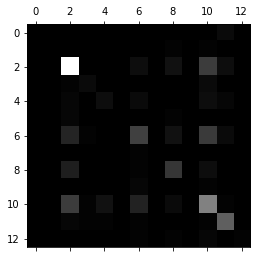

In [105]:
plt.matshow(conf_mat,cmap=plt.cm.gray)

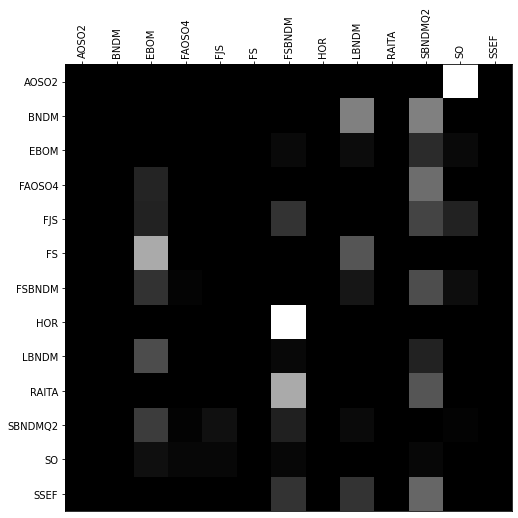

In [106]:
plt.figure(figsize=(8,8))
row_sums = conf_mat.sum(axis=1,keepdims=True)
normalize_row =conf_mat/row_sums
np.fill_diagonal(normalize_row,0) # FILL DIAGONALS WITH ZEROS PLOT ERRORS ONLY
plt.matshow(normalize_row,cmap=plt.cm.gray,fignum=1)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    # top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
_=plt.xticks(ticks=range(13),labels=labels_full_pipeline['labels'].categories_[0],rotation='vertical')
_=plt.yticks(ticks=range(13),labels=labels_full_pipeline['labels'].categories_[0])

Drop `FAOSO4,AOSO2,FS,SSEF,RAITA,BNDM,HOR` from training set and retrain the XGB Model.

-- Lets make one transformation class to drop rows which contains the mentioned algorithms

In [107]:
class LabelsDropper(BaseEstimator,TransformerMixin):
    def __init__(self,values):
        self.values = values

    def fit(self, X, y=None):
        return self

    def transform(self,X):
        for v in self.values:
            X = X[X.iloc[:,5] != v]
        print(X.shape)
        return X

In [108]:
strat_train[strat_train.iloc[:,5] != 'FAOSO4'].shape

(334, 7)

In [109]:
values = ['FAOSO4','AOSO2','FS','SSEF','RAITA','BNDM','HOR']
features_full_pipeline_new = ColumnTransformer([
                                            ("value_dropper",LabelsDropper(values),strat_train.columns),
                                            ("num_attr",numerical_pipe,num_attributes),
                                            ("cat_attr",OneHotEncoder(),cat_attributes),
])

In [110]:
# smart_features_new = features_full_pipeline_new.fit_transform(strat_train)
# smart_features_new.shape
strat_train.shape

(341, 7)

In [111]:
# for v in values:
#     strat_train = strat_train[strat_train['Algorithm'] != v]
# strat_train.shape

In [112]:
# smart_features_new = features_full_pipeline.fit_transform(strat_train)
# smart_labels_new = labels_full_pipeline.fit_transform(strat_train['Algorithm'].values.reshape(-1,1))

In [113]:
# X_train = smart_features_new.copy()
# y_train = smart_labels_new.copy()

# X_train.shape, y_train.shape

In [114]:
cross_val_score(xgb5,X_train,y_train,cv=4,scoring='accuracy').mean()

0.5395348837209303

In [115]:
y_pred = cross_val_predict(xgb5,X_train,y_train,cv=4)
conf_mat = confusion_matrix(y_train,y_pred)
conf_mat

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  1,  0,  0],
       [ 0,  0, 75,  0,  0,  0,  4,  0,  5,  0, 18,  4,  0],
       [ 0,  0,  1,  3,  0,  0,  0,  0,  0,  0,  3,  0,  0],
       [ 0,  0,  2,  0,  4,  0,  3,  0,  0,  0,  4,  2,  0],
       [ 0,  0,  2,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
       [ 0,  0, 11,  1,  0,  0, 19,  0,  5,  0, 17,  3,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  9,  0,  0,  0,  1,  0, 16,  0,  4,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  1,  0,  0],
       [ 0,  0, 18,  1,  5,  0, 10,  0,  3,  0, 38,  1,  0],
       [ 0,  0,  2,  1,  1,  0,  1,  0,  0,  0,  1, 28,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  0,  1,  0,  2,  0,  1]])

In [116]:
def confusion_table(estimator,switchoffdiagonal=False):
    y_pred = cross_val_predict(estimator,X_train,y_train,cv=4)
    # y_pred = cross_val_predict(estimator,X_train,y_train,cv=4)
    conf_mat = confusion_matrix(y_train,y_pred)
    plt.figure(figsize=(5,5))
    row_sums = conf_mat.sum(axis=1,keepdims=True)
    normalize_row =conf_mat/row_sums
    if(switchoffdiagonal):
        np.fill_diagonal(normalize_row,0) # FILL DIAGONALS WITH ZEROS PLOT ERRORS ONLY
    # plt.matshow(normalize_row,cmap=plt.cm.gray_r,fignum=1)
    ax = sns.heatmap(normalize_row,cmap='gray_r')
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=True,          # ticks along the top edge are off
        labeltop =True,         
        labelbottom=False) # labels along the bottom edge are off
    _=plt.xticks(ticks=np.arange(13)+0.5,labels=labels_full_pipeline['labels'].categories_[0],rotation='vertical',ha='center')
    _=plt.yticks(ticks=np.arange(13)+0.5,labels=labels_full_pipeline['labels'].categories_[0],rotation='horizontal',va='center')
    # plt.colorbar()
    ax.axhline(y=0, color='k',linewidth=2)
    ax.axhline(y=normalize_row.shape[1], color='k',linewidth=2)
    ax.axvline(x=0, color='k',linewidth=2)
    ax.axvline(x=normalize_row.shape[0], color='k',linewidth=2)
    return conf_mat

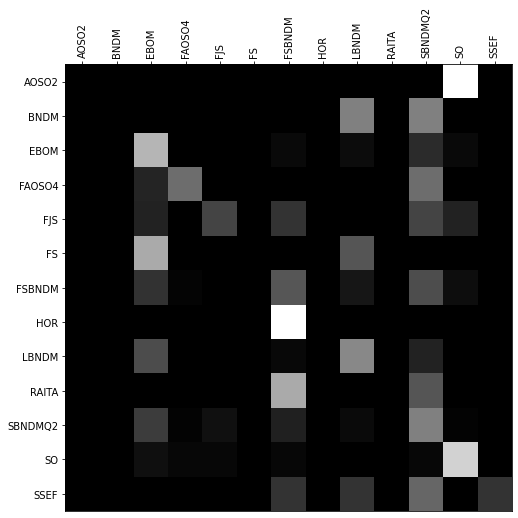

In [117]:
y_pred = cross_val_predict(xgb5,X_train,y_train,cv=4)
conf_mat = confusion_matrix(y_train,y_pred)
plt.figure(figsize=(8,8))
row_sums = conf_mat.sum(axis=1,keepdims=True)
normalize_row =conf_mat/row_sums
# np.fill_diagonal(normalize_row,0) # FILL DIAGONALS WITH ZEROS PLOT ERRORS ONLY
plt.matshow(normalize_row,cmap=plt.cm.gray,fignum=1)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    # top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
_=plt.xticks(ticks=range(13),labels=labels_full_pipeline['labels'].categories_[0],rotation='vertical')
_=plt.yticks(ticks=range(13),labels=labels_full_pipeline['labels'].categories_[0])

Saving figure xgb_confused_4


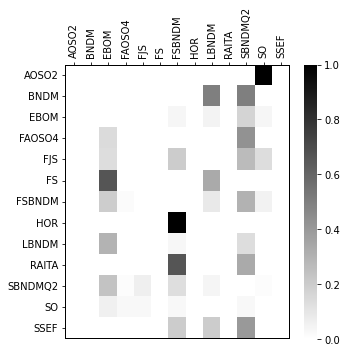

In [118]:
_=confusion_table(xgb5,switchoffdiagonal=True)
save_fig('xgb_confused_4')

#### A Closer look at Random Forest - Tune parameters

In [119]:
# # New look at the performance after dropping out less frequent data points
cross_val_score(RandomForestClassifier(),X_train,y_train,cv=4,scoring='accuracy').mean()

0.48683310533515733

In [120]:
# from sklearn.model_selection import RandomizedSearchCV
# # Number of trees in random forest
# n_estimators = [int(x) for x in range(50,500,50)]
# # Depth the random forest to grow
# max_depth = [int(x) for x in np.linspace(10,100,num=11)] + [None]
# # Minimum number of samples in a node to allow split
# min_samples_split = [2,5,10]
# # Max number of nodes in a leaf
# max_leaf_nodes = [None,1,2,4]
# # Minimum samples for a leaf node
# min_samples_leaf = [1,2,4]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Method of selecting samples for training each tree
# bootstrap = [True, False]

# random_grid = {
#     'n_estimators':n_estimators,
#     'max_depth':max_depth,
#     'min_samples_split':min_samples_split,
#     'max_leaf_nodes':max_leaf_nodes,
#     'min_samples_leaf':min_samples_leaf,
#     'max_features':max_features,
#     'bootstrap':bootstrap
# }
# rf = RandomForestClassifier(
#     random_state=2022
# )

# rf_random_search = RandomizedSearchCV(estimator=rf,
#                                       param_distributions=random_grid,
#                                       n_iter = 100,cv = 4, verbose=2)
# rf_random_search.fit(X_train,y_train)

In [121]:
# rf_random_search.cv_results_['mean_test_score'],rf_random_search.best_params_,rf_random_search.best_score_

In [122]:
# # A Grid Search based on the random cv
# grid_params = {
#     'max_depth': range(5,15),
#     'min_samples_leaf':[0,1,2,3],
#     'min_samples_split':[5,10,15],
#     'n_estimators':[425,450,475]
# }

# rf = RandomForestClassifier(
#     random_state=2022,
#     max_depth=10,
#     max_features='sqrt',
#     max_leaf_nodes = None,
#     min_samples_leaf = 1,
#     min_samples_split = 10,
#     n_estimators = 450
# )

# rf_grid_search = GridSearchCV(estimator=rf,
#                                       param_grid=grid_params,
#                                       cv = 4, verbose=2)
# rf_grid_search.fit(X_train,y_train)

# rf_grid_search.best_params_,rf_grid_search.best_score_

In [123]:
# # Max_depth hasn't converged yet, let's tune it further
# param = {
#     'max_depth':[4,6,8]
# }

# rf = RandomForestClassifier(
#     random_state=2022,
#     max_depth=6,
#     max_features='sqrt',
#     max_leaf_nodes = None,
#     min_samples_leaf = 1,
#     min_samples_split = 5,
#     n_estimators = 450
# )

# rf_grid_search = GridSearchCV(estimator=rf,
#                                       param_grid=param,
#                                       cv = 4, verbose=2)
# rf_grid_search.fit(X_train,y_train)

# rf_grid_search.best_params_,rf_grid_search.best_score_

In [124]:
# Final Random Forest Model
rf = RandomForestClassifier(
    random_state=2022,
    max_depth=6,
    max_features='sqrt',
    max_leaf_nodes = None,
    min_samples_leaf = 1,
    min_samples_split = 5,
    n_estimators = 450
)

Saving figure baseline_optimized


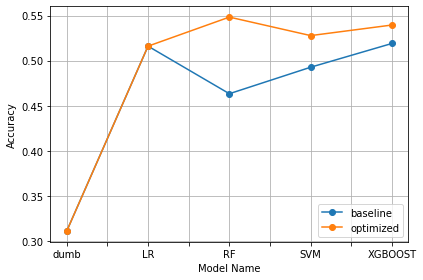

In [125]:
# Combine Base Results into a DataFrame

base_tuned_results = {
    'dumb':{'baseline':dumb,'optimized':dumb},
    'LR':{'baseline':lr_train_base,'optimized':lr_train_base},
    'RF':{'baseline':rf_base,'optimized':0.5483242134062928},
    'SVM':{'baseline':svc_base,'optimized':0.5278043775649794},
    'XGBOOST':{'baseline':xgboost_base,'optimized':0.5395348837209303}
}

base_df = pd.DataFrame(base_tuned_results)
base_df = base_df.T
base_df.columns=['baseline','optimized']
base_df.to_csv('baseline_oprimized.csv')
_=base_df.plot(kind='line', marker='o')
plt.grid()
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Model Name')
save_fig('baseline_optimized')

##### Error analysis for RF

Saving figure rf_confused_3


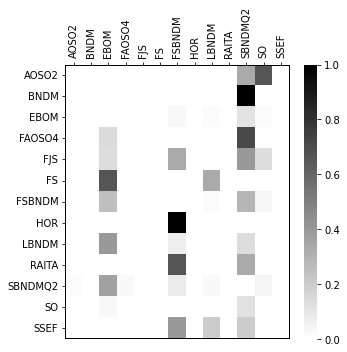

In [126]:
_=confusion_table(rf,switchoffdiagonal=True)
save_fig('rf_confused_3')

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  1,  0,  0],
       [ 0,  0, 75,  0,  0,  0,  4,  0,  5,  0, 18,  4,  0],
       [ 0,  0,  1,  3,  0,  0,  0,  0,  0,  0,  3,  0,  0],
       [ 0,  0,  2,  0,  4,  0,  3,  0,  0,  0,  4,  2,  0],
       [ 0,  0,  2,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
       [ 0,  0, 11,  1,  0,  0, 19,  0,  5,  0, 17,  3,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  9,  0,  0,  0,  1,  0, 16,  0,  4,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  1,  0,  0],
       [ 0,  0, 18,  1,  5,  0, 10,  0,  3,  0, 38,  1,  0],
       [ 0,  0,  2,  1,  1,  0,  1,  0,  0,  0,  1, 28,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  0,  1,  0,  2,  0,  1]])

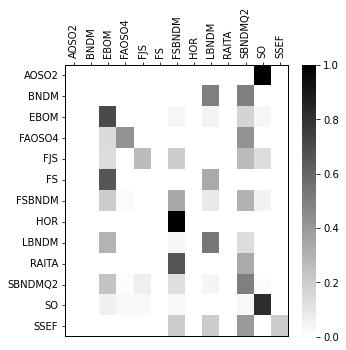

In [127]:
confusion_table(xgb5)

#### Time to try Ensemble Learning


In [128]:
from sklearn.ensemble import VotingClassifier
estimators = [('xgb', xgb5),('rf',rf)]
ensemble1 = VotingClassifier(estimators=estimators,voting='hard')
y_pred1 = cross_val_predict(ensemble1,X_train,y_train,cv=4)
cross_val_score(ensemble1,X_train,y_train,cv=4).mean()

0.542578659370725

In [129]:
from sklearn.metrics import classification_report
print(classification_report(y_train,y_pred1))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         3
         1.0       0.00      0.00      0.00         2
         2.0       0.56      0.83      0.67       106
         3.0       0.40      0.29      0.33         7
         4.0       0.50      0.27      0.35        15
         5.0       0.00      0.00      0.00         3
         6.0       0.49      0.43      0.46        56
         7.0       0.00      0.00      0.00         1
         8.0       0.55      0.40      0.46        30
         9.0       0.00      0.00      0.00         3
        10.0       0.43      0.37      0.40        76
        11.0       0.76      0.76      0.76        34
        12.0       1.00      0.20      0.33         5

    accuracy                           0.54       341
   macro avg       0.36      0.27      0.29       341
weighted avg       0.52      0.54      0.52       341



array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  2,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  1,  0,  0],
       [ 0,  0, 88,  0,  0,  0,  4,  0,  2,  0, 10,  2,  0],
       [ 0,  0,  2,  2,  0,  0,  0,  0,  0,  0,  3,  0,  0],
       [ 0,  0,  2,  0,  4,  0,  4,  0,  0,  0,  3,  2,  0],
       [ 0,  0,  2,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
       [ 0,  0, 15,  0,  0,  0, 24,  0,  3,  0, 13,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 13,  0,  0,  0,  3,  0, 12,  0,  2,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  1,  0,  0],
       [ 1,  0, 31,  2,  3,  0,  8,  0,  2,  0, 28,  1,  0],
       [ 0,  0,  3,  1,  1,  0,  1,  0,  0,  0,  2, 26,  0],
       [ 0,  0,  0,  0,  0,  0,  2,  0,  1,  0,  1,  0,  1]])

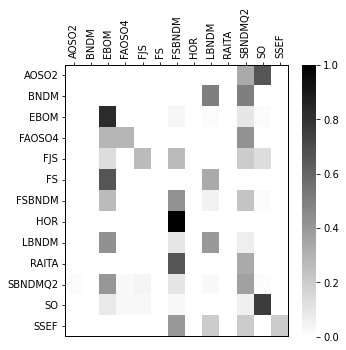

In [130]:
confusion_table(ensemble1)

#### Experimenting on Linear models

In [131]:
from sklearn.svm import SVC
svc = SVC(random_state=2022)
cross_val_score(svc,X_train,y_train,cv=4,scoring='accuracy').mean()

0.4927154582763338

In [132]:
from sklearn.model_selection import GridSearchCV
tune_params = [{'kernel': ['rbf'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5],
                     'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
                    {'kernel': ['sigmoid'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5],
                     'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
                    {'kernel': ['linear'], 'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]}
                   ]
cv_grid_search = GridSearchCV(estimator=svc,
                                      param_grid=tune_params,
                                      cv = 4, verbose=2)
cv_grid_search.fit(X_train,y_train)

cv_grid_search.best_params_,cv_grid_search.best_score_

Fitting 4 folds for each of 72 candidates, totalling 288 fits
[CV] END ....................C=0.001, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.001, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.001, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.001, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.001, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.001, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.001, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.001, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ..................C=0.001, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END ..................C=0.001, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END ..................C=0.001, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END ..................C=0.001, gamma=0.000

({'C': 1000, 'gamma': 0.001, 'kernel': 'sigmoid'}, 0.5278043775649794)

In [133]:
svc = SVC(
    C=1000,
    gamma=0.001,
    kernel='sigmoid',
    random_state=2022
)

array([[ 0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0],
       [ 0,  0,  1,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
       [ 0,  0, 80,  0,  0,  0,  6,  0,  2,  0, 15,  3,  0],
       [ 0,  0,  3,  1,  0,  0,  1,  0,  0,  0,  2,  0,  0],
       [ 0,  0,  2,  0,  0,  0,  6,  0,  0,  0,  6,  1,  0],
       [ 0,  0,  1,  0,  0,  0,  1,  0,  1,  0,  0,  0,  0],
       [ 0,  0, 12,  0,  0,  0, 29,  0,  4,  0, 11,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  7,  0,  0,  0,  3,  0, 17,  0,  3,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  1,  0,  0],
       [ 0,  0, 26,  0,  2,  0, 12,  0,  6,  0, 26,  4,  0],
       [ 1,  0,  0,  1,  0,  0,  2,  0,  0,  0,  4, 26,  0],
       [ 0,  0,  0,  0,  0,  0,  3,  0,  1,  0,  0,  0,  1]])

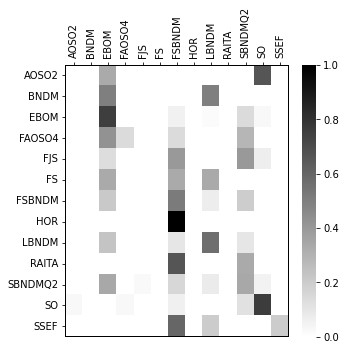

In [134]:
svc = SVC(**cv_grid_search.best_params_,random_state=2022,probability=True)
confusion_table(svc)

In [135]:
# How about Ensemble with SVC in? ----> bad
estimators = [('xgb', xgb5),('rf',rf),('svc',svc)]
ensemble = VotingClassifier(estimators=estimators,voting='hard')
y_pred = cross_val_predict(ensemble,X_train,y_train,cv=4)
cross_val_score(ensemble,X_train,y_train,cv=4).mean()


0.5482558139534883

Saving figure svc_confused_3


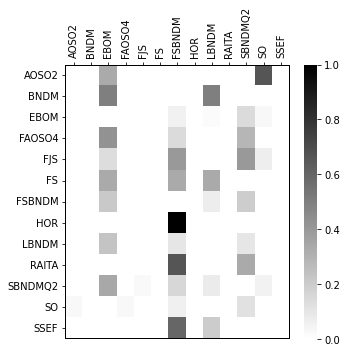

In [136]:
_=confusion_table(svc,switchoffdiagonal=True)
save_fig('svc_confused_3')

In [137]:
# Classification Report
from sklearn.metrics import classification_report
print(classification_report(y_train,y_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         3
         1.0       0.00      0.00      0.00         2
         2.0       0.58      0.77      0.66       106
         3.0       0.50      0.29      0.36         7
         4.0       0.00      0.00      0.00        15
         5.0       0.00      0.00      0.00         3
         6.0       0.51      0.45      0.48        56
         7.0       0.00      0.00      0.00         1
         8.0       0.53      0.53      0.53        30
         9.0       0.00      0.00      0.00         3
        10.0       0.44      0.43      0.44        76
        11.0       0.76      0.82      0.79        34
        12.0       1.00      0.20      0.33         5

    accuracy                           0.55       341
   macro avg       0.33      0.27      0.28       341
weighted avg       0.51      0.55      0.52       341



array([[ 0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  1,  0,  0],
       [ 0,  0, 82,  0,  0,  0,  4,  0,  4,  0, 13,  3,  0],
       [ 0,  0,  1,  2,  0,  0,  0,  0,  0,  0,  4,  0,  0],
       [ 0,  0,  2,  0,  0,  0,  6,  0,  0,  0,  5,  2,  0],
       [ 0,  0,  2,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
       [ 0,  0, 14,  0,  0,  0, 25,  0,  3,  0, 13,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 10,  0,  0,  0,  1,  0, 16,  0,  3,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  1,  0,  0],
       [ 1,  0, 28,  1,  1,  0,  7,  0,  4,  0, 33,  1,  0],
       [ 1,  0,  1,  1,  1,  0,  1,  0,  0,  0,  1, 28,  0],
       [ 0,  0,  0,  0,  0,  0,  2,  0,  1,  0,  1,  0,  1]])

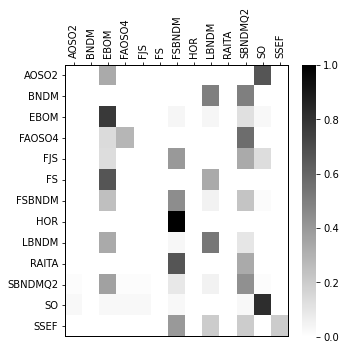

In [138]:
confusion_table(ensemble)

In [139]:
# LOGISTIC REGRESSION
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=2022)
cross_val_score(lr,X_train,y_train,cv=4,scoring='accuracy').mean()

0.5160738714090287

Saving figure lr_confused_3


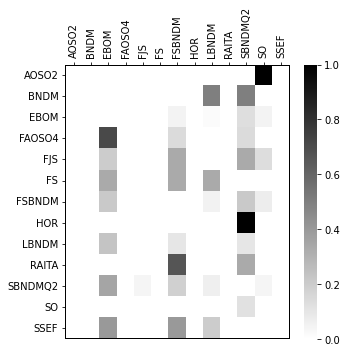

In [140]:
_=confusion_table(lr,switchoffdiagonal=True)
save_fig('lr_confused_3')

In [141]:
# How about Ensemble with lr in? ----> bad
estimators = [('xgb', xgb5),('rf',rf),('lr',lr)]
ensemble3 = VotingClassifier(estimators=estimators,voting='soft')
y_pred3 = cross_val_predict(ensemble3,X_train,y_train,cv=4)
cross_val_score(ensemble3,X_train,y_train,cv=4).mean()

0.5452804377564979

In [142]:
print(classification_report(y_train,y_pred3))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         3
         1.0       0.00      0.00      0.00         2
         2.0       0.59      0.76      0.67       106
         3.0       0.67      0.29      0.40         7
         4.0       0.00      0.00      0.00        15
         5.0       0.00      0.00      0.00         3
         6.0       0.48      0.38      0.42        56
         7.0       0.00      0.00      0.00         1
         8.0       0.52      0.53      0.52        30
         9.0       0.00      0.00      0.00         3
        10.0       0.45      0.46      0.45        76
        11.0       0.68      0.88      0.77        34
        12.0       1.00      0.20      0.33         5

    accuracy                           0.55       341
   macro avg       0.34      0.27      0.27       341
weighted avg       0.50      0.55      0.51       341



In [143]:
classification_report(y_train,y_pred,output_dict=True)

{'0.0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3},
 '1.0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2},
 '2.0': {'precision': 0.5815602836879432,
  'recall': 0.7735849056603774,
  'f1-score': 0.6639676113360323,
  'support': 106},
 '3.0': {'precision': 0.5,
  'recall': 0.2857142857142857,
  'f1-score': 0.36363636363636365,
  'support': 7},
 '4.0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 15},
 '5.0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3},
 '6.0': {'precision': 0.5102040816326531,
  'recall': 0.44642857142857145,
  'f1-score': 0.4761904761904762,
  'support': 56},
 '7.0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1},
 '8.0': {'precision': 0.5333333333333333,
  'recall': 0.5333333333333333,
  'f1-score': 0.5333333333333333,
  'support': 30},
 '9.0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3},
 '10.0': {'precision': 0.44,
  'recall': 0.4342105263157895,
  '

In [144]:
def highlight_max(s):
    max = s == s.max()
    return ['background-color:yellow' if v else '' for v in max]

def classification_table(y_train,y_pred,labels):
    report_dic = classification_report(y_train,y_pred,output_dict=True)
    df_indices = dict()
    for i,k in enumerate(labels):
        df_indices[str(float(i))] = k
    report_dic['accuracy'] = {'f1-score':report_dic['accuracy'],
                              'precision':np.nan,
                              'recall':np.nan,
                              'support':report_dic['macro avg']['support']}
    df = pd.DataFrame(report_dic)

    df = df.T.rename(index=df_indices)
    cm = sns.light_palette("green", as_cmap=True)

    # df.style.apply(highlight_max)
    with pd.option_context('display.precision', 2):
        df_style = df.style.bar(subset=['support'], color='#d65f5f').background_gradient(cmap=cm, low=.5, high=0).format(None,na_rep="")
    # df_style.to_excel('styled.xlsx', engine='openpyxl')
    return df_style
    # background_gradient(cmap='summer')

labels = labels_full_pipeline['labels'].categories_[0]
classification_table(y_train,y_pred3,labels)

,precision,recall,f1-score,support
AOSO2,0.00,0.00,0.00,3.00
BNDM,0.00,0.00,0.00,2.00
EBOM,0.59,0.76,0.67,106.00
FAOSO4,0.67,0.29,0.40,7.00
FJS,0.00,0.00,0.00,15.00
FS,0.00,0.00,0.00,3.00
FSBNDM,0.48,0.38,0.42,56.00
HOR,0.00,0.00,0.00,1.00
LBNDM,0.52,0.53,0.52,30.00
RAITA,0.00,0.00,0.00,3.00


## How does it look on a test set?

In [145]:
# smart_features.toarray()

In [146]:
smart_features = features_full_pipeline.fit_transform(strat_test)
smart_labels = labels_full_pipeline.fit_transform(strat_test['Algorithm'].values.reshape(-1,1))
ensemble3.fit(X_train,y_train)
y_pred_test = ensemble3.predict(smart_features)
classification_table(smart_labels,y_pred_test,labels)

,precision,recall,f1-score,support
AOSO2,0.00,0.00,0.00,3.00
BNDM,0.00,0.00,0.00,2.00
EBOM,0.62,0.74,0.67,46.00
FAOSO4,0.00,0.00,0.00,3.00
FJS,0.00,0.00,0.00,13.00
FS,0.00,0.00,0.00,3.00
FSBNDM,0.55,0.32,0.40,19.00
HOR,0.00,0.00,0.00,1.00
LBNDM,0.31,0.44,0.36,9.00
RAITA,0.00,0.00,0.00,1.00


In [147]:
estimators = [('xgb', xgb5),('rf',rf),('svc',svc),('lr',lr)]
final_ensemble = VotingClassifier(estimators=estimators,voting='soft')
final_ensemble.fit(X_train,y_train)
y_pred_test = final_ensemble.predict(smart_features)
classification_table(smart_labels,y_pred_test,labels)

,precision,recall,f1-score,support
AOSO2,0.00,0.00,0.00,3.00
BNDM,0.00,0.00,0.00,2.00
EBOM,0.62,0.74,0.67,46.00
FAOSO4,0.00,0.00,0.00,3.00
FJS,0.00,0.00,0.00,13.00
FS,0.00,0.00,0.00,3.00
FSBNDM,0.58,0.37,0.45,19.00
HOR,0.00,0.00,0.00,1.00
LBNDM,0.31,0.44,0.36,9.00
RAITA,0.00,0.00,0.00,1.00


Saving figure baseline_optimized


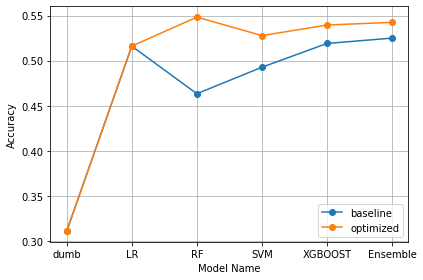

In [149]:
# Base Ensemble Results
estimatorz = [('xgb', XGBClassifier()),('rf',RandomForestClassifier()),('svc',SVC()),('lr',LogisticRegression())]
base_ensemble = VotingClassifier(estimators=estimatorz,voting='hard')
ensemble_base = cross_val_score(base_ensemble,X_train,y_train,cv=4).mean()
# Final Ensemble Results
ensemble_tuned = cross_val_score(final_ensemble,X_train,y_train,cv=4).mean()
ensemble_tuned
# Combine Base Results into a DataFrame

base_tuned_results = {
    'dumb':{'baseline':dumb,'optimized':dumb},
    'LR':{'baseline':lr_train_base,'optimized':lr_train_base},
    'RF':{'baseline':rf_base,'optimized':0.5483242134062928},
    'SVM':{'baseline':svc_base,'optimized':0.5278043775649794},
    'XGBOOST':{'baseline':xgboost_base,'optimized':0.5395348837209303},
    'Ensemble':{'baseline':ensemble_base,'optimized':ensemble_tuned}
}

base_df = pd.DataFrame(base_tuned_results)
base_df = base_df.T
base_df.columns=['baseline','optimized']
base_df.to_csv('baseline_oprimized.csv')
_=base_df.plot(kind='line', marker='o')
plt.grid()
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Model Name')
save_fig('baseline_optimized')

Saving figure baseline_optimized_2


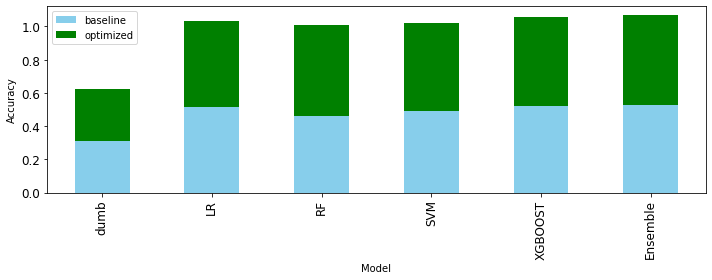

In [150]:
ax=base_df.plot(kind='bar',stacked=True, color=['skyblue', 'green'],figsize=(10, 4),ylabel='Accuracy',
                xlabel='Model',fontsize='12')
# ax.bar_label(ax.containers[0])
save_fig('baseline_optimized_2')

In [151]:
ensemble_tuned - 0.5483242134062928

-0.0058481532147743875

Saving figure ensemble_confused_3


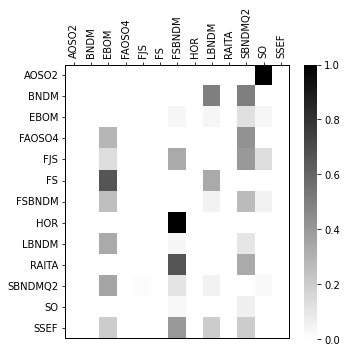

In [152]:
_=confusion_table(final_ensemble,switchoffdiagonal=True)
save_fig('ensemble_confused_3')

### Top-k accuracy

In [153]:
from sklearn.metrics import top_k_accuracy_score
# cross_val_predict(rf,X_train,y_train,cv=4,method="predict_proba")

In [154]:
rf.fit(X_train,y_train)
rf_pred_train=rf.predict_proba(X_train)
top_k_accuracy_score(y_train,rf_pred_train,k=3)

0.9589442815249267

In [155]:
rf_pred_test = rf.predict_proba(smart_features)
top_k_accuracy_score(smart_labels,rf_pred_test,k=3)

0.7755102040816326

In [156]:
matching_data

,Category,Text Size [MB],Pattern Length,Alphabet Size,Time [ms],Algorithm,Best Algo,speed
0,rand2,1.0,2,2.0,0.00,AOSO2,NaN,inf
1,rand2,1.0,4,2.0,14.37,AOSO2,NaN,0.067958
2,rand2,1.0,8,2.0,6.56,AOSO2,NaN,0.148866
3,rand2,1.0,16,2.0,1.83,AOSO2,NaN,0.533641
4,rand2,1.0,32,2.0,1.33,AOSO2,NaN,0.734258
...,...,...,...,...,...,...,...,...
8635,englishTexts,50.0,64,128.0,202.82,TW,NaN,0.240746
8636,englishTexts,50.0,128,128.0,191.96,TW,NaN,0.254366
8637,englishTexts,50.0,256,128.0,194.42,TW,NaN,0.251148
8638,englishTexts,50.0,512,128.0,192.47,TW,NaN,0.253692


In [157]:

# Revert transformed data
numerical_pipe_reverse = Pipeline([
                           ('add_drop_attributes',AttributesAdder(dropTime=False)),
                           ('log_scaler',FunctionTransformer(func=np.expm1, validate=True))
                           ])

def reverseTransform(tr_data_feature,tr_data_label,model_prediction):
    if (type(tr_data_feature) != np.ndarray):
        tr_data_feature = tr_data_feature.toarray()
    # reverse text_category
    onehot = features_full_pipeline.named_transformers_.cat_attr.categories_[0]
    indices = np.argmax(tr_data_feature[:,3:],axis=1)
    df = pd.DataFrame(indices).apply(lambda x:onehot[x])

    # reverse Text Size [MB]	Pattern Length	Alphabet Size
    num_features = numerical_pipe_reverse.fit_transform(tr_data_feature[:,:3])
    df_num = pd.DataFrame(num_features,columns=[1,2,3])

    # reverse label/Best Algo
    label = labels_full_pipeline['labels'].categories_[0]
    df_label = pd.DataFrame(tr_data_label.astype('int'),columns=[4]).apply(lambda a:label[a])

    # reverse Model Prediction to labels
    df_model_prediction = pd.DataFrame(model_prediction.astype('int'),columns=[5]).apply(lambda a:label[a])
    # Columns
    columns = ["Category","Text Size [MB]","Pattern Length","Alphabet Size","Best Algo","Model Prediction"]
    # Concatenate DF's
    df = df.join(df_num).join(df_label).join(df_model_prediction)
    df.columns=columns

    return df

def computeTimeGivenColumnsValues(master,a,b,c,d,e):
    query = "Category==@a & `Text Size [MB]`==@b & `Pattern Length`==@c & `Alphabet Size`==@d & `Algorithm`==@e"
    # print(a,b,c,d,e)
    return master.query(query)['Time [ms]'].values[0]


def timeRatio(smart_master_database,model_data):
    
    totalActualTime = 0
    totalPredictionTime = 0
    for values in model_data.values:
        (a,b,c,d,e) = values[:5]
        totalActualTime += computeTimeGivenColumnsValues(
            smart_master_database,
            a,
            np.round(b,0),
            np.round(c,0),
            np.round(d,0),
            e
            )
        (a,b,c,d) = values[:4]
        e = values[5]
        totalPredictionTime += computeTimeGivenColumnsValues(
            smart_master_database,
            a,
            np.round(b,0),
            np.round(c,0),
            np.round(d,0),
            e
            )
    return totalActualTime/totalPredictionTime



def assemble_performance(model_list,k,X_train,y_train,dataset,X_test=smart_features.toarray(),y_test=smart_labels,master_database=matching_data):
    stats = dict()
    for name,model in model_list:
        stats_m = dict()
        # Compute precision, recall, f1-score, samples
        if dataset == 'Test':
            model = model.fit(X_train,y_train)
            y_pred = model.predict(X_test)
            rep = classification_report(y_test,y_pred,output_dict=True)
        else:
            y_pred = cross_val_predict(model,X_train,y_train,cv=4)
            rep = classification_report(y_train,y_pred,output_dict=True)

        
        stats_m['Precision']=rep['weighted avg']['precision']
        stats_m['Recall']=rep['weighted avg']['recall']
        stats_m['F1-score']=rep['weighted avg']['f1-score']

        # Top k scores
        if dataset == 'Test':
            y_pred_top_k = model.predict_proba(X_test)
        else:
            y_pred_top_k = model.fit(X_train,y_train).predict_proba(X_train)

        for i in range(1,k+1):
            if dataset == 'Test':
                stats_m['Top-'+str(i)+'-accuracy']=top_k_accuracy_score(y_test,y_pred_top_k,k=i)
            else:
                stats_m['Top-'+str(i)+'-accuracy']=top_k_accuracy_score(y_train,y_pred_top_k,k=i)
        # stats_m['Dataset'] = dataset

        # New Metric-->Time Ratio
        if dataset == 'Test':
            model_df = reverseTransform(X_test,y_test,y_pred)
        else:
            model_df = reverseTransform(X_train,y_train,y_pred)
        stats_m['Time-Ratio'] = timeRatio(master_database,model_df)

        stats_m['Samples']=y_pred.size
        
        stats[str(name)] = stats_m
        
    # DF
    df = pd.DataFrame(data=stats)
    return df

In [158]:
strat_train

,Category,Text Size [MB],Pattern Length,Alphabet Size,Time [ms],Algorithm,Best Algo
12,rand2,5.0,128,2.0,3.93,EBOM,EBOM
292,rand250,1.0,32,250.0,0.24,SBNDMQ2,SBNDMQ2
246,rand128,1.0,8,128.0,0.35,FSBNDM,FSBNDM
50,rand4,1.0,64,4.0,0.49,SBNDMQ2,SBNDMQ2
217,rand64,5.0,2,64.0,7.25,FSBNDM,FSBNDM
...,...,...,...,...,...,...,...
34,rand2,50.0,512,2.0,34.14,EBOM,EBOM
220,rand64,5.0,32,64.0,2.12,FSBNDM,FSBNDM
239,rand64,50.0,4,64.0,46.08,FSBNDM,FSBNDM
314,rand250,10.0,1024,250.0,2.35,LBNDM,LBNDM


In [159]:
matching_data

,Category,Text Size [MB],Pattern Length,Alphabet Size,Time [ms],Algorithm,Best Algo,speed
0,rand2,1.0,2,2.0,0.00,AOSO2,NaN,inf
1,rand2,1.0,4,2.0,14.37,AOSO2,NaN,0.067958
2,rand2,1.0,8,2.0,6.56,AOSO2,NaN,0.148866
3,rand2,1.0,16,2.0,1.83,AOSO2,NaN,0.533641
4,rand2,1.0,32,2.0,1.33,AOSO2,NaN,0.734258
...,...,...,...,...,...,...,...,...
8635,englishTexts,50.0,64,128.0,202.82,TW,NaN,0.240746
8636,englishTexts,50.0,128,128.0,191.96,TW,NaN,0.254366
8637,englishTexts,50.0,256,128.0,194.42,TW,NaN,0.251148
8638,englishTexts,50.0,512,128.0,192.47,TW,NaN,0.253692


In [160]:
type(y_train) == np.ndarray

True

In [161]:
df=reverseTransform(X_train,y_train,y_pred)
timeRatio(matching_data,df)
# df.values[:,:6][0]
# df

0.9403655906987839

In [162]:
model_list = [('Random Forest',rf),
              ('Extreme Gradient Boosting',xgb5),
              ('Support Vector Machine',svc),
              ('Logistic Regression',lr),
              ('Ensemble',final_ensemble)
              ]

df_train = assemble_performance(model_list,3,X_train,y_train,dataset='Train')
df_train.T

,Precision,Recall,F1-score,Top-1-accuracy,Top-2-accuracy,Top-3-accuracy,Time-Ratio,Samples
Random Forest,0.507286,0.548387,0.513113,0.700880,0.873900,0.958944,0.946234,341.0
Extreme Gradient Boosting,0.518335,0.539589,0.520945,0.700880,0.879765,0.956012,0.921713,341.0
Support Vector Machine,0.488027,0.527859,0.498419,0.568915,0.736070,0.897361,0.908441,341.0
Logistic Regression,0.446845,0.516129,0.475751,0.568915,0.747801,0.894428,0.899424,341.0
Ensemble,0.489836,0.542522,0.505905,0.665689,0.838710,0.932551,0.924933,341.0


In [163]:
# Modified function
df_train_m = assemble_performance(model_list,3,X_train,y_train,dataset='Train')
df_train_m.T
# df_train_m.T.to_csv('train data.csv')

,Precision,Recall,F1-score,Top-1-accuracy,Top-2-accuracy,Top-3-accuracy,Time-Ratio,Samples
Random Forest,0.507286,0.548387,0.513113,0.700880,0.873900,0.958944,0.946234,341.0
Extreme Gradient Boosting,0.518335,0.539589,0.520945,0.700880,0.879765,0.956012,0.921713,341.0
Support Vector Machine,0.488027,0.527859,0.498419,0.568915,0.736070,0.897361,0.908441,341.0
Logistic Regression,0.446845,0.516129,0.475751,0.568915,0.747801,0.894428,0.899424,341.0
Ensemble,0.489836,0.542522,0.505905,0.665689,0.838710,0.932551,0.924933,341.0


In [166]:
# df_test = assemble_performance(model_list,3,smart_features.toarray(),smart_labels,dataset='Test')
# df_test.T
# df_test.T.to_csv('test data.csv')

In [164]:
# Modified Test Function
df_test_m = assemble_performance(model_list,3,X_train,y_train,dataset='Test')
df_test.T.to_csv('test data.csv')
df_test_m.T

,Precision,Recall,F1-score,Top-1-accuracy,Top-2-accuracy,Top-3-accuracy,Time-Ratio,Samples
Random Forest,0.419169,0.510204,0.455944,0.510204,0.673469,0.775510,0.938080,147.0
Extreme Gradient Boosting,0.496485,0.319728,0.307154,0.319728,0.591837,0.734694,0.704343,147.0
Support Vector Machine,0.382293,0.455782,0.414682,0.482993,0.693878,0.775510,0.836582,147.0
Logistic Regression,0.397152,0.476190,0.429629,0.476190,0.646259,0.768707,0.861018,147.0
Ensemble,0.415084,0.482993,0.434861,0.482993,0.659864,0.789116,0.928621,147.0


In [165]:
def beautify(df):
    cm = sns.light_palette("green", as_cmap=True)
    # df.style.apply(highlight_max)
    with pd.option_context('display.precision', 4):
        df_style = df.style.background_gradient(cmap=cm, low=.5, high=0).format(None,na_rep="")
    # df_style.to_excel('styled.xlsx', engine='openpyxl')
    return df_style

In [167]:
beautify(df_train.T)

,Precision,Recall,F1-score,Top-1-accuracy,Top-2-accuracy,Top-3-accuracy,Time-Ratio,Samples
Random Forest,0.5073,0.5484,0.5131,0.7009,0.8739,0.9589,0.9462,341.0000
Extreme Gradient Boosting,0.5183,0.5396,0.5209,0.7009,0.8798,0.9560,0.9217,341.0000
Support Vector Machine,0.4880,0.5279,0.4984,0.5689,0.7361,0.8974,0.9084,341.0000
Logistic Regression,0.4468,0.5161,0.4758,0.5689,0.7478,0.8944,0.8994,341.0000
Ensemble,0.4898,0.5425,0.5059,0.6657,0.8387,0.9326,0.9249,341.0000


In [168]:
beautify(df_test.T)

,227,266,483,108,132,406,383,109,350,7,377,119,384,163,162,333,204,126,416,316,284,215,449,170,245,99,110,157,184,347,422,467,225,81,150,453,400,221,339,394,353,458,318,462,267,164,230,343,465,297,129,233,76,388,116,86,48,75,97,100,112,294,106,381,140,432,256,127,371,92,45,359,46,460,328,342,475,334,398,322,455,430,179,374,193,205,138,287,101,273,393,207,446,203,254,196,33,72,133,348,411,197,252,161,471,62,313,98,22,29,52,392,107,211,53,192,360,367,183,448,262,407,214,437,303,120,36,378,85,464,425,114,336,447,473,40,176,128,38,177,26,428,274,42,338,321,171
Category,rand64,rand128,englishTexts,rand8,rand16,genome,genome,rand8,protein,rand2,genome,rand8,genome,rand32,rand32,protein,rand64,rand16,italianTexts,rand250,rand250,rand64,englishTexts,rand32,rand128,rand8,rand8,rand16,rand32,protein,italianTexts,englishTexts,rand64,rand4,rand16,englishTexts,genome,rand64,protein,genome,protein,englishTexts,rand250,englishTexts,rand128,rand32,rand64,protein,englishTexts,rand250,rand16,rand64,rand4,genome,rand8,rand8,rand4,rand4,rand8,rand8,rand8,rand250,rand8,genome,rand16,italianTexts,rand128,rand16,genome,rand8,rand4,protein,rand4,englishTexts,protein,protein,englishTexts,protein,genome,rand250,englishTexts,italianTexts,rand32,genome,rand32,rand64,rand16,rand250,rand8,rand128,genome,rand64,italianTexts,rand64,rand128,rand32,rand2,rand4,rand16,protein,italianTexts,rand32,rand128,rand16,englishTexts,rand4,rand250,rand8,rand2,rand2,rand4,genome,rand8,rand64,rand4,rand32,protein,genome,rand32,englishTexts,rand128,genome,rand64,italianTexts,rand250,rand8,rand2,genome,rand8,englishTexts,italianTexts,rand8,protein,italianTexts,englishTexts,rand2,rand32,rand16,rand2,rand32,rand2,italianTexts,rand128,rand4,protein,rand250,rand32
Text Size [MB],10.0000,10.0000,50.0000,10.0000,5.0000,50.0000,5.0000,10.0000,10.0000,1.0000,1.0000,50.0000,5.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,50.0000,1.0000,5.0000,1.0000,1.0000,1.0000,5.0000,10.0000,50.0000,10.0000,10.0000,5.0000,5.0000,10.0000,50.0000,10.0000,1.0000,50.0000,5.0000,5.0000,10.0000,10.0000,5.0000,50.0000,5.0000,10.0000,1.0000,10.0000,5.0000,5.0000,5.0000,1.0000,50.0000,50.0000,10.0000,50.0000,1.0000,1.0000,50.0000,5.0000,5.0000,50.0000,1.0000,10.0000,5.0000,5.0000,10.0000,5.0000,1.0000,1.0000,5.0000,1.0000,50.0000,1.0000,5.0000,1.0000,5.0000,10.0000,1.0000,50.0000,50.0000,1.0000,10.0000,5.0000,1.0000,50.0000,1.0000,5.0000,1.0000,5.0000,10.0000,10.0000,1.0000,50.0000,1.0000,5.0000,50.0000,50.0000,50.0000,5.0000,10.0000,1.0000,50.0000,1.0000,50.0000,10.0000,10.0000,10.0000,5.0000,10.0000,10.0000,5.0000,10.0000,10.0000,1.0000,5.0000,50.0000,50.0000,1.0000,10.0000,1.0000,5.0000,50.0000,5.0000,10.0000,5.0000,50.0000,50.0000,5.0000,1.0000,5.0000,5.0000,50.0000,1.0000,50.0000,10.0000,50.0000,5.0000,1.0000,50.0000,5.0000,10.0000,10.0000,50.0000,1.0000,5.0000,50.0000,1.0000
Pattern Length,4,2,1024,512,16,2,16,1024,128,2,4,8,32,2,4,64,128,16,8,128,1024,512,512,512,2,4,16,1024,8,8,512,4,16,4,32,1024,128,1024,16,32,32,8,2,256,4,8,32,64,128,256,128,64,512,64,256,32,256,256,1024,16,4,128,128,512,64,128,2,32,512,8,128,128,512,16,2,8,256,128,8,1024,16,16,8,32,128,512,4,1024,2,8,16,64,16,4,64,2,256,8,128,16,128,256,256,2,4,8,64,64,128,4,256,1024,256,256,512,4,256,8,2,4,512,4,256,64,4,32,32,64,16,1024,16,64,1024,2,16,16,16,64,4,128,32,8,512,2,4,32,1024
Alphabet Size,64.0000,128.0000,128.0000,8.0000,16.0000,64.0000,64.0000,8.0000,64.0000,2.0000,64.0000,8.0000,64.0000,32.0000,32.0000,64.0000,64.0000,16.0000,128.0000,250.0000,250.0000,64.0000,128.0000,32.0000,128.0000,8.0000,8.0000,16.0000,32.0000,64.0000,128.0000,128.0000,64.0000,4.0000,16.0000,128.0000,64.0000,64.0000,64.0000,64.0000,64.0000,128.0000,250.0000,128.0000,128.0000,32.0000,64.0000,64.0000,128.0000,250.0000,16.0000,64.0000,4.0000,64.0000,8.0000,8.0000,4.0000,4.0000,8.0000,8.0000,8.0000,250.0000,8.0000,64.0000,16.0000,128.0000,128.0000,16.0000,64.0000,8.0000,4.0000,64.0000,4.0000,128.0000,64.0000,64.0000,128.0000,64.0000,64.0000,250.0000,128.0000,12

In [169]:
beautify(df_train_m.T)

,Precision,Recall,F1-score,Top-1-accuracy,Top-2-accuracy,Top-3-accuracy,Time-Ratio,Samples
Random Forest,0.5073,0.5484,0.5131,0.7009,0.8739,0.9589,0.9462,341.0000
Extreme Gradient Boosting,0.5183,0.5396,0.5209,0.7009,0.8798,0.9560,0.9217,341.0000
Support Vector Machine,0.4880,0.5279,0.4984,0.5689,0.7361,0.8974,0.9084,341.0000
Logistic Regression,0.4468,0.5161,0.4758,0.5689,0.7478,0.8944,0.8994,341.0000
Ensemble,0.4898,0.5425,0.5059,0.6657,0.8387,0.9326,0.9249,341.0000


In [170]:
beautify(df_test_m.T)

,Precision,Recall,F1-score,Top-1-accuracy,Top-2-accuracy,Top-3-accuracy,Time-Ratio,Samples
Random Forest,0.4192,0.5102,0.4559,0.5102,0.6735,0.7755,0.9381,147.0000
Extreme Gradient Boosting,0.4965,0.3197,0.3072,0.3197,0.5918,0.7347,0.7043,147.0000
Support Vector Machine,0.3823,0.4558,0.4147,0.4830,0.6939,0.7755,0.8366,147.0000
Logistic Regression,0.3972,0.4762,0.4296,0.4762,0.6463,0.7687,0.8610,147.0000
Ensemble,0.4151,0.4830,0.4349,0.4830,0.6599,0.7891,0.9286,147.0000


In [171]:
# Export table of results
df_train_m.T.to_csv('train set.csv',index=True);
df_test_m.T.to_csv('test set.csv',index=True);

#### How does RF suggests given some conditions?

In [172]:
strat_train_rf = strat_train.copy()
predicted_algo_rf_train = rf.predict(X_train)
strat_train_rf['RF Model Prediction'] = predicted_algo_rf_train
strat_train_rf

,Category,Text Size [MB],Pattern Length,Alphabet Size,Time [ms],Algorithm,Best Algo,RF Model Prediction
12,rand2,5.0,128,2.0,3.93,EBOM,EBOM,2.0
292,rand250,1.0,32,250.0,0.24,SBNDMQ2,SBNDMQ2,10.0
246,rand128,1.0,8,128.0,0.35,FSBNDM,FSBNDM,6.0
50,rand4,1.0,64,4.0,0.49,SBNDMQ2,SBNDMQ2,10.0
217,rand64,5.0,2,64.0,7.25,FSBNDM,FSBNDM,6.0
...,...,...,...,...,...,...,...,...
34,rand2,50.0,512,2.0,34.14,EBOM,EBOM,2.0
220,rand64,5.0,32,64.0,2.12,FSBNDM,FSBNDM,10.0
239,rand64,50.0,4,64.0,46.08,FSBNDM,FSBNDM,6.0
314,rand250,10.0,1024,250.0,2.35,LBNDM,LBNDM,8.0


In [173]:
#strat_test
predicted_algo_rf = rf.predict(smart_features.toarray())
predicted_algo_rf

array([ 6.,  6.,  2.,  2., 10., 11., 10.,  2.,  2., 11., 11.,  2., 10.,
       10., 10., 10., 10., 10., 10., 12.,  8.,  2.,  8., 10.,  6.,  2.,
        2.,  2., 10., 10.,  8., 10., 10., 11.,  2.,  8.,  2.,  2., 10.,
       10., 10., 10.,  6.,  8.,  6., 10., 10.,  2.,  2.,  6., 10.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  6.,  2.,  2.,  2.,
        8.,  6., 10.,  2.,  2.,  2.,  2.,  2., 10., 11., 10.,  2., 10.,
       11., 12., 10., 10., 10., 10.,  2.,  2., 10.,  8., 11.,  6., 10.,
       10., 10., 10.,  6.,  6.,  2., 11.,  2., 10.,  8.,  2., 10., 11.,
       10., 11.,  6.,  2.,  2., 11.,  2.,  2.,  2.,  2.,  2., 10.,  2.,
       11.,  6., 10.,  8., 11.,  2.,  8., 10.,  2.,  2.,  2.,  2.,  2.,
       10.,  2., 10., 10., 10., 11., 10., 10., 11.,  2.,  2., 10., 10.,
       11., 10.,  6., 10.])

In [174]:
labels_ = labels_full_pipeline['labels'].categories_
labels_

[array(['AOSO2', 'BNDM', 'EBOM', 'FAOSO4', 'FJS', 'FS', 'FSBNDM', 'HOR',
        'LBNDM', 'RAITA', 'SBNDMQ2', 'SO', 'SSEF'], dtype=object)]

In [175]:
# Convert back to categories
labels_ = labels_full_pipeline['labels'].categories_
rf_predictions = [labels_[0][int(tag)] for tag in predicted_algo_rf]

In [176]:
# strat_test
strat_test_rf = strat_test.copy()
strat_test_rf = strat_test_rf.reset_index().drop('index', axis=1)
strat_test_rf['RF Model Prediction'] = predicted_algo_rf
# strat_test_rf.to_csv('rf_predictions.csv')
strat_test_rf

,Category,Text Size [MB],Pattern Length,Alphabet Size,Time [ms],Algorithm,Best Algo,RF Model Prediction
0,rand64,10.0,4,64.0,8.66,FSBNDM,FSBNDM,6.0
1,rand128,10.0,2,128.0,14.95,FSBNDM,FSBNDM,6.0
2,englishTexts,50.0,1024,128.0,24.03,EBOM,EBOM,2.0
3,rand8,10.0,512,8.0,4.40,EBOM,EBOM,2.0
4,rand16,5.0,16,16.0,1.78,EBOM,EBOM,10.0
...,...,...,...,...,...,...,...,...
142,rand128,50.0,512,128.0,21.93,EBOM,EBOM,10.0
143,rand4,1.0,2,4.0,1.97,EBOM,EBOM,11.0
144,protein,5.0,4,64.0,2.47,FJS,FJS,10.0
145,rand250,50.0,32,250.0,24.51,FSBNDM,FSBNDM,6.0


In [177]:
# Combine RF predictions
full_rf_prediction_data = strat_train_rf.append(strat_test_rf)
# full_rf_prediction_data.to_csv('full predicted data by RF.csv')
full_rf_prediction_data

,Category,Text Size [MB],Pattern Length,Alphabet Size,Time [ms],Algorithm,Best Algo,RF Model Prediction
12,rand2,5.0,128,2.0,3.93,EBOM,EBOM,2.0
292,rand250,1.0,32,250.0,0.24,SBNDMQ2,SBNDMQ2,10.0
246,rand128,1.0,8,128.0,0.35,FSBNDM,FSBNDM,6.0
50,rand4,1.0,64,4.0,0.49,SBNDMQ2,SBNDMQ2,10.0
217,rand64,5.0,2,64.0,7.25,FSBNDM,FSBNDM,6.0
...,...,...,...,...,...,...,...,...
142,rand128,50.0,512,128.0,21.93,EBOM,EBOM,10.0
143,rand4,1.0,2,4.0,1.97,EBOM,EBOM,11.0
144,protein,5.0,4,64.0,2.47,FJS,FJS,10.0
145,rand250,50.0,32,250.0,24.51,FSBNDM,FSBNDM,6.0


In [178]:
full_rf_prediction_data['Category'].unique()

array(['rand2', 'rand250', 'rand128', 'rand4', 'rand64', 'englishTexts',
       'rand32', 'protein', 'genome', 'rand16', 'italianTexts', 'rand8'],
      dtype=object)

In [179]:
# strat_test_rf['Category_num'] = strat_test_rf['Category'].astype('category').cat.codes
# strat_test_rf['RF Model Prediction num'] = strat_test_rf['RF Model Prediction'].astype('category').cat.codes
# strat_test_rf['RF Model Prediction num']
full_rf_prediction_data['Category_num'] = full_rf_prediction_data['Category'].astype('category').cat.codes

# Build a custom label encoder
cust_labels = ['rand2','rand4','rand8','rand16','rand32','rand64','rand128','rand250','englishTexts',
               'italianTexts','genome','protein'
               ]
cust_labels = ['rand2','rand4','rand8','rand16','rand32','rand64','rand128','rand250','genome','protein',
               'englishTexts','italianTexts'
               ]
full_rf_prediction_data['Category_num_cust'] = full_rf_prediction_data['Category'].apply(lambda x:cust_labels.index(x))
# full_rf_prediction_data['Category_num_cust']

In [180]:
# Query data when size == 5
reduced_data = full_rf_prediction_data.query('`Text Size [MB]`==5')
reduced_data.shape

(120, 10)

In [181]:
df_heatmap = reduced_data[['Category_num_cust','Pattern Length','RF Model Prediction']]
y = [2,4,8,16,32,64,128,256,512,1024]
data = np.zeros((10,12))
for yy in range(10):
    for xx in range(12):
        data[yy,xx] = np.array(df_heatmap.query('Category_num_cust==@xx & `Pattern Length`==@y[@yy]')['RF Model Prediction'])[0]
data

array([[11., 11., 11.,  6.,  6.,  6.,  6.,  6., 11., 11., 11., 10.],
       [11., 11.,  2., 10., 10.,  6.,  6., 10., 11., 10., 10., 10.],
       [11., 11.,  2., 10., 10.,  6.,  6., 10., 11., 10., 10., 10.],
       [11.,  3.,  2., 10., 10., 10.,  6., 10., 10., 10., 10., 10.],
       [10.,  3.,  2., 10., 10., 10.,  6., 10., 10., 10., 10., 10.],
       [ 2.,  2.,  2.,  2.,  2.,  2.,  6., 10.,  2.,  2.,  2.,  8.],
       [ 2.,  2.,  2.,  2.,  2.,  2.,  6.,  6.,  2.,  2.,  2.,  8.],
       [ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  6.,  2.,  2.,  8.,  8.],
       [ 2.,  2.,  2.,  2.,  2.,  2.,  8.,  8.,  2.,  2.,  8.,  8.],
       [ 2.,  2.,  2.,  2.,  2.,  2., 10.,  8.,  2.,  2.,  2.,  8.]])

In [182]:
set(data.flatten())

{2.0, 3.0, 6.0, 8.0, 10.0, 11.0}

In [183]:
# # Create Data to create heat map
# x = list(reduced_data['Category_num'])
# y = list(reduced_data['Pattern Length'].astype(int))
# z = list(reduced_data['RF Model Prediction'])

# data = np.zeros((len(y),len(x)))

# for i,yy in enumerate(y):
#     for j,xx in enumerate(x):
#         data[i,j] = z[j]

# data
# len(z)

In [184]:
categories = reduced_data['Category'].unique()
categories.sort()
categories

array(['englishTexts', 'genome', 'italianTexts', 'protein', 'rand128',
       'rand16', 'rand2', 'rand250', 'rand32', 'rand4', 'rand64', 'rand8'],
      dtype=object)

In [185]:
#lab[2:]
#np.arange(int(data.min()),int(data.max()+1)
lab = labels_full_pipeline['labels'].categories_[0]
data.shape
#{2.0, 3.0, 6.0, 8.0, 10.0, 11.0}
labels_new = [lab[int(k)] for k in list(set(data.flatten()))]
labels_new

['EBOM', 'FAOSO4', 'FSBNDM', 'LBNDM', 'SBNDMQ2', 'SO']

Saving figure RF performance map


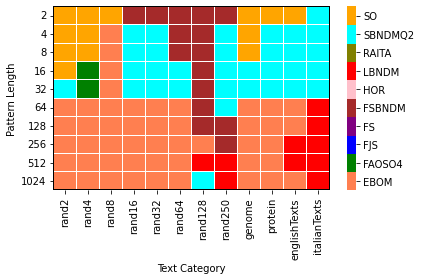

In [186]:
from matplotlib import colors
lab = labels_full_pipeline['labels'].categories_[0]
# colormap = sns.diverging_palette(250, 250, as_cmap=True) #'viridis'
# Define discrete color maps
colormap = colors.ListedColormap(['Coral', 'Green', 'Blue','Purple','Brown','Pink','Red','Olive','Cyan','Orange'])
ax = sns.heatmap(data.astype(int), linewidths=.01, cmap=colormap,vmin=1.5, vmax=11.5)
# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=True,          # ticks along the top edge are off
#     labeltop =True,         
#     labelbottom=False) # labels along the bottom edge are off
_=plt.xticks(ticks=np.arange(12)+0.5,labels=cust_labels,rotation='vertical',ha='center')
_=plt.yticks(ticks=np.arange(10)+0.5,labels=y,rotation='horizontal',va='center')
# plt.colorbar()
# labels_full_pipeline['labels'].categories_[0]
ax.axhline(y=0, color='k',linewidth=2)
ax.axhline(y=data.shape[0], color='k',linewidth=2)
ax.axvline(x=0, color='k',linewidth=2)
ax.axvline(x=data.shape[1], color='k',linewidth=2)
ticks = np.arange(int(data.min()),int(data.max()+1))
# ax.clim(-0.5, 11.5)
ax.collections[0].colorbar.set_ticks(ticks)
ax.collections[0].colorbar.set_ticklabels(lab[2:])
plt.ylabel('Pattern Length')
plt.xlabel('Text Category')
save_fig('RF performance map')

In [187]:
# RF predicts only these ones #{2.0, 3.0, 6.0, 8.0, 10.0, 11.0}
# To produce ticks need to replace data entry from 0 to 5, to have a continuos ticks
data_entries = list(set(data.flatten()))
data_new = np.zeros((10,12))
for i in range(10):
    for j in range(12):
        data_new[i][j] = data_entries.index(data[i][j])

data_new

array([[5., 5., 5., 2., 2., 2., 2., 2., 5., 5., 5., 4.],
       [5., 5., 0., 4., 4., 2., 2., 4., 5., 4., 4., 4.],
       [5., 5., 0., 4., 4., 2., 2., 4., 5., 4., 4., 4.],
       [5., 1., 0., 4., 4., 4., 2., 4., 4., 4., 4., 4.],
       [4., 1., 0., 4., 4., 4., 2., 4., 4., 4., 4., 4.],
       [0., 0., 0., 0., 0., 0., 2., 4., 0., 0., 0., 3.],
       [0., 0., 0., 0., 0., 0., 2., 2., 0., 0., 0., 3.],
       [0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 3., 3.],
       [0., 0., 0., 0., 0., 0., 3., 3., 0., 0., 3., 3.],
       [0., 0., 0., 0., 0., 0., 4., 3., 0., 0., 0., 3.]])

Saving figure RF performance map final 4


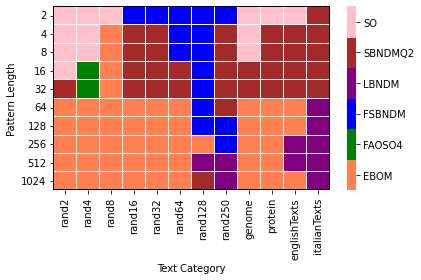

In [188]:
from matplotlib import colors
# lab = labels_full_pipeline['labels'].categories_[0]
# colormap = sns.diverging_palette(250, 250, as_cmap=True) #'viridis'
# Define discrete color maps
colormap = colors.ListedColormap(['Coral', 'Green', 'Blue','Purple','Brown','Pink'])
ax = sns.heatmap(data_new.astype(int), linewidths=.01, cmap=colormap,vmin=-0.5, vmax=5.5)
# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=True,          # ticks along the top edge are off
#     labeltop =True,         
#     labelbottom=False) # labels along the bottom edge are off
_=plt.xticks(ticks=np.arange(12)+0.5,labels=cust_labels,rotation='vertical',ha='center')
_=plt.yticks(ticks=np.arange(10)+0.5,labels=y,rotation='horizontal',va='center')
# plt.colorbar()
# labels_full_pipeline['labels'].categories_[0]
ax.axhline(y=0, color='k',linewidth=2)
ax.axhline(y=data.shape[0], color='k',linewidth=2)
ax.axvline(x=0, color='k',linewidth=2)
ax.axvline(x=data.shape[1], color='k',linewidth=2)
ticks = np.arange(int(data.min()),int(data.max()+1))
# ax.clim(-0.5, 11.5)
ax.collections[0].colorbar.set_ticks(range(6))
ax.collections[0].colorbar.set_ticklabels(labels_new)
plt.ylabel('Pattern Length')
plt.xlabel('Text Category')
save_fig('RF performance map final 4')

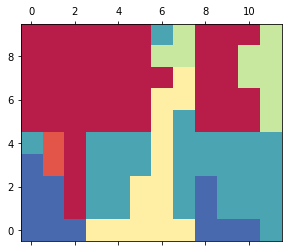

In [189]:
# use matshow to present the heat map
fig, ax = plt.subplots()
ms = ax.matshow(data, cmap = plt.cm.get_cmap('Spectral') , vmin=data.min() - 0.5, vmax=data.max() + 0.5, origin = 'lower')
# # x and y axis ticks
# ax.set_xticklabels([str(xx) for xx in range(12)])
# ax.set_yticklabels([str(yy) for yy in y])
# ax.xaxis.tick_bottom()

# # Put the x- qnd y-axis ticks at the middle of each cell 
# ax.set_xticks(np.arange(data.shape[1]), minor = False)
# ax.set_yticks(np.arange(data.shape[0]), minor = False)

# # Set custom ticks and ticklabels for color bar
# cbar = fig.colorbar(ms,ticks = np.arange(np.min(data),np.max(data)+1))
# # cbar.ax.set_yticklabels(colorbar_ticklabels)

# Summary and Conclusion